In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu

In [3]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=5, max_count=1000000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [4]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler


In [5]:
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [472]:
resolution_human = 10000
species = "human"
SRP_name = "aggregates"
resolution = "10kbp_raw"



input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])


In [612]:
    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    else:

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')
    

In [8]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path

In [ ]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_ranked_inter.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [473]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_ranked_inter.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [474]:
my_percen = np.nanpercentile(my_data, 99, axis=1, keepdims=True)


my_data_thresh = my_data > my_percen

my_data_thresh = my_data_thresh.astype(int)


df_gene_tp = pd.DataFrame(my_data_thresh ,  index=[x.decode() for x in gene_list.tolist()], columns = bins_bed.tolist())


In [475]:
exp_genes = pd.read_csv("/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/Homo_sapiens_average_rank.csv")

exp_genes['genes'] = [x.split('.')[0] for x in exp_genes['genes']]

exp_genes.set_index('genes', inplace=True)

exp_genes['avg_rank'] = exp_genes.sum(axis=1)

exp_genes['avg_rank'] = [ x/ exp_genes.shape[1] for x in  exp_genes['avg_rank']]

exp_genes = exp_genes[['avg_rank']]

exp_genes.reset_index(inplace=True)

exp_genes.drop_duplicates(['genes'], inplace=True)

high_auc_gene = exp_genes[exp_genes['avg_rank'] > 0.7]['genes'].tolist()

df_gene_tp_sel = df_gene_tp[df_gene_tp.index.isin(high_auc_gene)]


In [476]:
df_gene_tp_sel_sum = df_gene_tp.T.sum(axis=1).reset_index()

df_gene_tp_sel_sum['score'] = df_gene_tp_sel_sum[0]



In [477]:
df_gene_tp_sel_sum['score'].max()


50531

In [532]:
high_depth = d2_depth[d2_depth['quintile_score'] > 8]['gene_id_exp_file'].tolist()

In [533]:
df_gene_tp_sel = df_gene_tp[df_gene_tp.index.isin(high_depth)]


In [537]:
df_gene_tp_sel_sum = df_gene_tp_sel.T.sum(axis=1).reset_index()

df_gene_tp_sel_sum['score'] = df_gene_tp_sel_sum[0]

(0.0, 400.0)

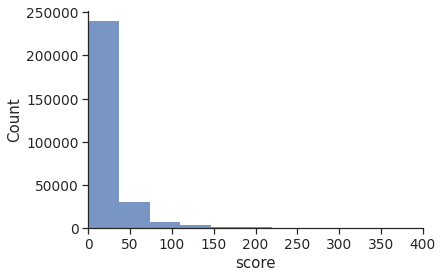

In [538]:
ax = sns.histplot(df_gene_tp_sel_sum['score'], bins=1000)
ax.set_xlim([0,400])

In [535]:
df_gene_tp_sel

0       1       2       3       4       5       6       \
ENSG00000000419       0       0       0       0       0       0       0   
ENSG00000000457       0       0       0       0       0       0       0   
ENSG00000000460       0       0       0       0       0       0       0   
ENSG00000000938       0       0       0       0       0       0       0   
ENSG00000001036       0       0       0       0       0       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
ENSG00000285492       0       0       0       0       0       0       0   
ENSG00000285498       0       0       0       0       0       0       0   
ENSG00000285508       0       0       0       0       0       0       0   
ENSG00000285509       0       0       0       0       0       0       0   
ENSG00000285513       0       0       0       0       0       0       0   

                 7       8       9       ...  287499  287500  287501  287502  \
ENSG00000000419       0       0       0  ...       0       0       0       0   
ENSG00000000457       0       0       0  ...       0       0       0       0   
ENSG00000000460       0       0       0  ...       0       0       0       0   
ENSG00000000938       0       0       0  ...       0       0       0       0   
ENSG00000001036       0       0       0  ...       0       0       0       0   
...                 ...     ...     ...  ...     ...     ...     ...     ...   
ENSG00000285492       0       0       0  ...       0       0       0       0   
ENSG00000285498       0       0       0  ...       0       0       0       0   
ENSG00000285508       0       0       0  ...       0       0       0       0   
ENSG00000285509       0       0       0  ...       0       0       0       0   
ENSG00000285513       0       0       0  ...       0       0       0       0   

                 287503  287504  287505  287506  287507  287508  
ENSG00000000419       0       0       0       0       0       0  
ENSG00000000457       0       0       0       0       0       0  
ENSG00000000460       0       0       0       0       0       0  
ENSG00000000938       0       0       0       0       0       0  
ENSG00000001036       0       0       0       0       0       0  
...                 ...     ...     ...     ...     ...     ...  
ENSG00000285492       0       0       0       0       0       0  
ENSG00000285498       0       0       0       0       0       0  
ENSG00000285508       0       0       0       0       0       0  
ENSG00000285509       0       0       0       0       0       0  
ENSG00000285513       0       0       0       0       0       0  

[38783 rows x 287509 columns]

(0.0, 1000.0)

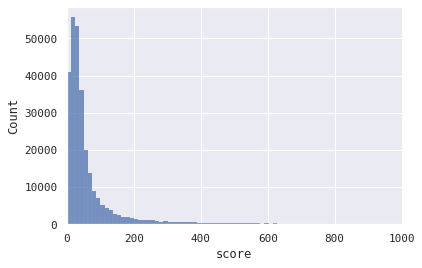

In [502]:
ax = sns.histplot(df_gene_tp_sel_sum['score'], bins=1000)
ax.set_xlim([0,1000])


(0.0, 1000.0)

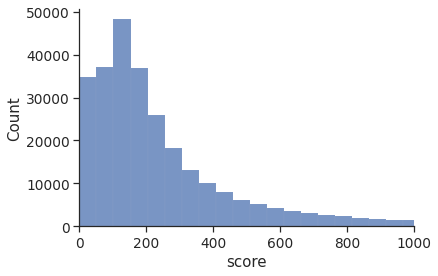

In [461]:
ax = sns.histplot(df_gene_tp_sel_sum['score'], bins=1000)
ax.set_xlim([0,1000])

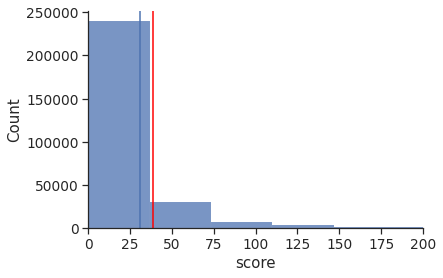

In [577]:
ax = sns.histplot(df_gene_tp_sel_sum['score'], bins=1000)
ax.set_xlim([0,200])
ax.axvline(30.8)
ax.axvline(39, color='red')

(0.0, 10.0)

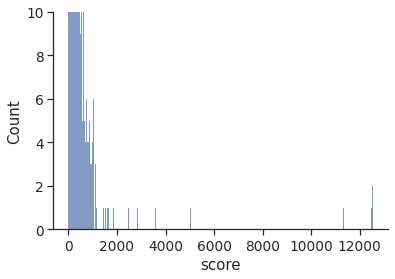

In [491]:
ax = sns.histplot(df_gene_tp_sel_sum['score'], bins=1000)
ax.set_ylim([0,10])
ax.set_xlim([0,10])

In [499]:
df_gene_tp_sel_sum[df_gene_tp_sel_sum['score'] > 14]

index    0  score
1            1   43     43
5            5   71     71
6            6   71     71
7            7   44     44
8            8  105    105
...        ...  ...    ...
287492  287492  141    141
287504  287504  105    105
287505  287505   61     61
287506  287506   70     70
287507  287507   33     33

[40667 rows x 3 columns]

In [501]:
40667/287509

0.14144600690760986

In [481]:
df_gene_tp_sel_sum = df_gene_tp_sel.T.sum(axis=1).reset_index()

df_gene_tp_sel_sum['score'] = df_gene_tp_sel_sum[0]


In [463]:
df_gene_tp_sel_sum['score'].mean()

372.38418275601805

In [480]:
df_gene_tp_sel_sum['score'].mean()

42.41133321043863

In [482]:
df_gene_tp_sel_sum['score'].mean()

10.887700906754223

In [570]:
df_gene_tp_sel_sum['score'].mean()

30.806712137706995

In [571]:
df_gene_tp_sel

0       1       2       3       4       5       6       \
ENSG00000000419       0       0       0       0       0       0       0   
ENSG00000000457       0       0       0       0       0       0       0   
ENSG00000000460       0       0       0       0       0       0       0   
ENSG00000000938       0       0       0       0       0       0       0   
ENSG00000001036       0       0       0       0       0       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
ENSG00000285492       0       0       0       0       0       0       0   
ENSG00000285498       0       0       0       0       0       0       0   
ENSG00000285508       0       0       0       0       0       0       0   
ENSG00000285509       0       0       0       0       0       0       0   
ENSG00000285513       0       0       0       0       0       0       0   

                 7       8       9       ...  287499  287500  287501  287502  \
ENSG00000000419       0       0       0  ...       0       0       0       0   
ENSG00000000457       0       0       0  ...       0       0       0       0   
ENSG00000000460       0       0       0  ...       0       0       0       0   
ENSG00000000938       0       0       0  ...       0       0       0       0   
ENSG00000001036       0       0       0  ...       0       0       0       0   
...                 ...     ...     ...  ...     ...     ...     ...     ...   
ENSG00000285492       0       0       0  ...       0       0       0       0   
ENSG00000285498       0       0       0  ...       0       0       0       0   
ENSG00000285508       0       0       0  ...       0       0       0       0   
ENSG00000285509       0       0       0  ...       0       0       0       0   
ENSG00000285513       0       0       0  ...       0       0       0       0   

                 287503  287504  287505  287506  287507  287508  
ENSG00000000419       0       0       0       0       0       0  
ENSG00000000457       0       0       0       0       0       0  
ENSG00000000460       0       0       0       0       0       0  
ENSG00000000938       0       0       0       0       0       0  
ENSG00000001036       0       0       0       0       0       0  
...                 ...     ...     ...     ...     ...     ...  
ENSG00000285492       0       0       0       0       0       0  
ENSG00000285498       0       0       0       0       0       0  
ENSG00000285508       0       0       0       0       0       0  
ENSG00000285509       0       0       0       0       0       0  
ENSG00000285513       0       0       0       0       0       0  

[38783 rows x 287509 columns]

In [464]:
df_gene_tp_sel_sum

index     0  score  true_pos  score2  true_neg
0            0     0      0         0       0       1.0
1            1   366    366         0     366       1.0
2            2    62     62         0      62       1.0
3            3   151    151         0     151       1.0
4            4   112    112         0     112       1.0
...        ...   ...    ...       ...     ...       ...
287504  287504  1457   1457         0    1457       1.0
287505  287505   778    778         0     778       1.0
287506  287506   771    771         0     771       1.0
287507  287507   200    200         0     200       1.0
287508  287508     0      0         0       0       1.0

[287509 rows x 6 columns]

In [465]:
df_gene_tp

0       1       2       3       4       5       6       \
ENSG00000000419       0       0       0       0       0       0       0   
ENSG00000000457       0       0       0       0       0       0       0   
ENSG00000000460       0       0       0       0       0       0       0   
ENSG00000000938       0       0       0       0       0       0       0   
ENSG00000000971       0       0       0       0       0       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
ENSG00000285498       0       0       0       0       0       0       0   
ENSG00000285505       0       0       0       0       0       0       0   
ENSG00000285508       0       0       0       0       0       0       0   
ENSG00000285509       0       0       0       0       0       0       0   
ENSG00000285513       0       0       0       0       0       0       0   

                 7       8       9       ...  287499  287500  287501  287502  \
ENSG00000000419       0       0       0  ...       0       0       0       0   
ENSG00000000457       0       0       0  ...       0       0       0       0   
ENSG00000000460       0       0       0  ...       0       0       0       0   
ENSG00000000938       0       0       0  ...       0       0       0       0   
ENSG00000000971       0       0       0  ...       0       0       0       0   
...                 ...     ...     ...  ...     ...     ...     ...     ...   
ENSG00000285498       0       0       0  ...       0       0       0       0   
ENSG00000285505       0       0       0  ...       0       0       0       0   
ENSG00000285508       0       0       0  ...       0       0       0       0   
ENSG00000285509       0       0       0  ...       0       0       0       0   
ENSG00000285513       0       0       0  ...       0       0       0       0   

                 287503  287504  287505  287506  287507  287508  
ENSG00000000419       0       0       0       0       0       0  
ENSG00000000457       0       0       0       0       0       0  
ENSG00000000460       0       0       0       0       0       0  
ENSG00000000938       0       0       0       0       0       0  
ENSG00000000971       0       0       0       0       0       0  
...                 ...     ...     ...     ...     ...     ...  
ENSG00000285498       0       0       0       0       0       0  
ENSG00000285505       0       0       0       0       0       0  
ENSG00000285508       0       0       0       0       0       0  
ENSG00000285509       0       0       0       0       0       0  
ENSG00000285513       0       0       0       0       0       0  

[55411 rows x 287509 columns]

In [466]:
55411 /100

554.11

In [18]:
def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(x)
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()


In [615]:
    df_cre_tog = df_cre_1kb_encode.merge(df_gene_tp_sel_sum, left_on='bin_id', right_on='index', how='right')

    df_cre_tog['cre'] = df_cre_tog['cre'].fillna(0)


    df_cre_tog['true_pos'] =  [1.0 if x>0 else 0 for x in df_cre_tog['cre']]

    df_cre_tog['true_neg'] = [0 if x == 1.0 else 1.0 for x in df_cre_tog['true_pos']]
    calc_auroc (df_cre_tog,predicted_score='score')

        

0.712231432217127

In [626]:
df_cre

chr     start       end            t1            t2  \
0       Chrom     Start      Stop          rDHS          cCRE   
1        chr1    181251    181601  EH38D2115304  EH38E1310153   
2        chr1    190865    191071  EH38D2115305  EH38E1310154   
3        chr1    778562    778912  EH38D2115324  EH38E1310158   
4        chr1    779086    779355  EH38D2115325  EH38E1310159   
...       ...       ...       ...           ...           ...   
926531   chrY  56842374  56842545  EH38D4327456  EH38E2776491   
926532   chrY  56844431  56844674  EH38D4327461  EH38E2776496   
926533   chrY  56857410  56857680  EH38D4327481  EH38E2776512   
926534   chrY  56857917  56858119  EH38D4327482  EH38E2776513   
926535   chrY  56868183  56868435  EH38D4327485  EH38E2776514   

                          t3    Group        n1        n2  phylop  \
0                 cCRE class    Group  N (>90%)  N (>50%)  phyloP   
1            pELS,CTCF-bound  group-3         1         3    0.08   
2            dELS,CTCF-bound  group-1       128       219   -0.20   
3             PLS,CTCF-bound  group-3         0         1   -2.15   
4             PLS,CTCF-bound  group-2        22       174    2.47   
...                      ...      ...       ...       ...     ...   
926531       dELS,CTCF-bound  group-3         0         0     0.0   
926532       dELS,CTCF-bound  group-3         0         0     0.0   
926533  CTCF-only,CTCF-bound  group-3        28        29    0.38   
926534  CTCF-only,CTCF-bound  group-3        31        31   -0.22   
926535  CTCF-only,CTCF-bound  group-2        35        54   -0.32   

             distance_to_tss         te  
0       Distance to TSS (bp)         TE  
1                       1095  Satellite  
2                       2907      other  
3                          0       None  
4                        115   SINE/Alu  
...                      ...        ...  
926531                 12699  Satellite  
926532                 10570  Satellite  
926533                  2167        LTR  
926534                  2674    LINE/L1  
926535                 12940        LTR  

[926536 rows x 12 columns]

In [1]:
    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/andrew2023/datas1.tsv', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3', 'Group', 'n1', 'n2', 'phylop', 'distance_to_tss', 'te'], skiprows=1)

    else:
        print ("m")

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre['g'] =  [x.split('-')[1] if x !='other' else 0 for x in df_cre['Group']]
    df_cre = df_cre.groupby(['start_bin'])['g'].max().reset_index()
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

#pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/andrew2023/datas1.tsv', sep='\t')

NameError: name 'species' is not defined

In [ ]:
df_cre_1kb_encode

In [650]:
df_cre.groupby('Group')['phylop'].mean()

Group
group-1    0.608314
group-2   -0.018311
group-3   -0.003476
other      0.002012
Name: phylop, dtype: float64

In [635]:
    df_cre_tog = df_cre_1kb_encode.merge(df_gene_tp_sel_sum, left_on='bin_id', right_on='index', how='right')

    #df_cre_tog['cre'] = df_cre_tog['cre'].fillna(0)


    df_cre_tog['true_pos'] =  [1.0 if x>0 else 0 for x in df_cre_tog['cre']]

    df_cre_tog['true_neg'] = [0 if x == 1.0 else 1.0 for x in df_cre_tog['true_pos']]
    calc_auroc (df_cre_tog,predicted_score='score')

        

KeyError: 'cre'

<AxesSubplot:xlabel='phylop', ylabel='score'>

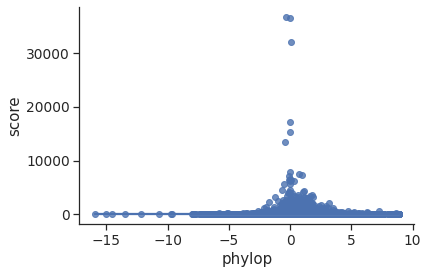

In [640]:
sns.regplot(data=df_cre_tog.dropna(), y='score', x='phylop')

In [409]:
calc_auroc (df_cre_tog,predicted_score='score')


0.7623435946896636

In [ ]:
df_gene_tp_sel_sum = df_gene_tp_sel.T.sum(axis=1).reset_index()

df_gene_tp_sel_sum['score'] = df_gene_tp_sel_sum[0]


In [20]:
df_gene_tp_sel_sum


index    0  score
0            0    0      0
1            1  110    110
2            2   10     10
3            3   35     35
4            4   27     27
...        ...  ...    ...
287504  287504  506    506
287505  287505  262    262
287506  287506  255    255
287507  287507   61     61
287508  287508    0      0

[287509 rows x 3 columns]

In [469]:
df_gene_tp_sel


0       1       2       3       4       5       6       \
ENSG00000000419       0       0       0       0       0       0       0   
ENSG00000000457       0       0       0       0       0       0       0   
ENSG00000000460       0       0       0       0       0       0       0   
ENSG00000000938       0       0       0       0       0       0       0   
ENSG00000000971       0       0       0       0       0       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
ENSG00000285280       0       0       0       0       0       0       0   
ENSG00000285331       0       0       0       0       0       0       0   
ENSG00000285399       0       0       0       0       0       0       0   
ENSG00000285410       0       0       0       0       0       0       0   
ENSG00000285437       0       0       0       0       0       0       0   

                 7       8       9       ...  287499  287500  287501  287502  \
ENSG00000000419       0       0       0  ...       0       0       0       0   
ENSG00000000457       0       0       0  ...       0       0       0       0   
ENSG00000000460       0       0       0  ...       0       0       0       0   
ENSG00000000938       0       0       0  ...       0       0       0       0   
ENSG00000000971       0       0       0  ...       0       0       0       0   
...                 ...     ...     ...  ...     ...     ...     ...     ...   
ENSG00000285280       0       0       0  ...       0       0       0       0   
ENSG00000285331       0       0       0  ...       0       0       0       0   
ENSG00000285399       0       0       0  ...       0       0       0       0   
ENSG00000285410       0       0       0  ...       0       0       0       0   
ENSG00000285437       0       0       0  ...       0       0       0       0   

                 287503  287504  287505  287506  287507  287508  
ENSG00000000419       0       0       0       0       0       0  
ENSG00000000457       0       0       0       0       0       0  
ENSG00000000460       0       0       0       0       0       0  
ENSG00000000938       0       0       0       0       0       0  
ENSG00000000971       0       0       0       0       0       0  
...                 ...     ...     ...     ...     ...     ...  
ENSG00000285280       0       0       0       0       0       0  
ENSG00000285331       0       0       0       0       0       0  
ENSG00000285399       0       0       0       0       0       0  
ENSG00000285410       0       0       0       0       0       0  
ENSG00000285437       0       1       0       0       0       0  

[13158 rows x 287509 columns]

In [450]:
auc_ll = []
for each_gene in df_gene_tp_sel.index.tolist():
    df_gene_tp_sel_sum['true_pos'] = df_gene_tp_sel.T[each_gene]
    
    df_gene_tp_sel_sum['score2'] = df_gene_tp_sel_sum['score'] - df_gene_tp_sel_sum['true_pos']

    df_gene_tp_sel_sum['true_neg'] = [0 if x == 1.0 else 1.0 for x in df_gene_tp_sel_sum['true_pos']]

    auc_ll.append(calc_auroc(df_gene_tp_sel_sum,predicted_score='score2'))
    
    

In [190]:
auc_ll = []
gene_ll = []
for each_gene in df_gene_tp.index.tolist():
    df_gene_tp_sel_sum['true_pos'] = df_gene_tp.T[each_gene]
    
    df_gene_tp_sel_sum['score2'] = df_gene_tp_sel_sum['score'] - df_gene_tp_sel_sum['true_pos']

    df_gene_tp_sel_sum['true_neg'] = [0 if x == 1.0 else 1.0 for x in df_gene_tp_sel_sum['true_pos']]

    auc_ll.append(calc_auroc(df_gene_tp_sel_sum,predicted_score='score2'))
    gene_ll.append(each_gene)
    
    

In [24]:
len(auc_ll)



13158

In [193]:
len(auc_ll)


55411

In [195]:
auc_ll

[0.9129826683226459,
 0.7298339634957149,
 0.6514541920282456,
 0.9503367001840279,
 0.5920934112937621,
 0.7606954491355606,
 0.7317053491497688,
 0.8913564376261421,
 0.8966352701064819,
 0.9015602119209242,
 0.6924632419011267,
 0.9565874437086276,
 0.5975458038700884,
 0.6994148148001006,
 0.7616367277342161,
 0.7672403849079771,
 0.9080668146996181,
 0.8636640974810869,
 0.9773746505618783,
 0.85999126560017,
 0.7233870966070923,
 0.8018438744530086,
 0.675329906832918,
 0.6582437746328194,
 0.8972256822183412,
 0.9649540579075326,
 0.9480416051398939,
 0.8046441685373513,
 0.8560506602682357,
 0.7809033610172894,
 0.6763340419252115,
 0.955371418195878,
 0.7686137933559343,
 0.8434785628570128,
 0.8566048042383669,
 0.6042107861910654,
 0.8180734003456577,
 0.9500824954516373,
 0.6661628241931369,
 0.7164026908948117,
 0.7700207516945917,
 0.9377152956977293,
 0.9440376981477642,
 0.9044113656299212,
 0.7464605784083854,
 0.6845890148124876,
 0.9433196842638766,
 0.88943590878663

In [194]:
sum(auc_ll)/len(auc_ll)


nan

In [196]:
sum(auc_ll)

nan

<AxesSubplot:ylabel='Count'>

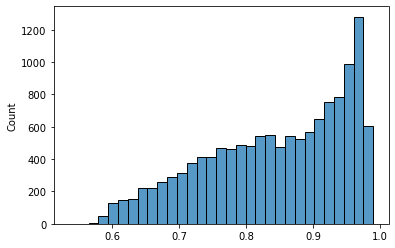

In [26]:
%matplotlib inline
import seaborn as sns
sns.histplot(auc_ll)


<AxesSubplot:ylabel='Count'>

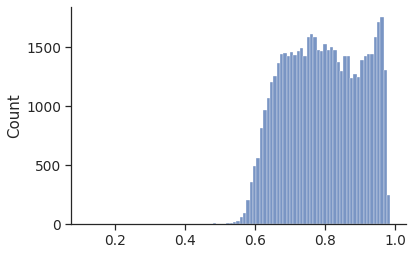

In [606]:
%matplotlib inline
import seaborn as sns
sns.histplot(auc_ll)


<AxesSubplot:ylabel='Count'>

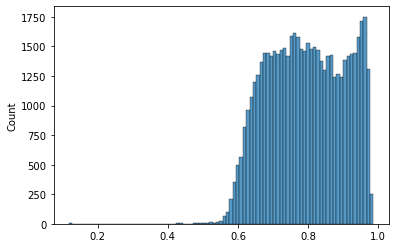

In [197]:
sns.histplot(auc_ll)

In [579]:
d2['auc_de'].mean()

0.794695681018479

In [315]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)
import joypy

In [324]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
auc_GO_terms_manw_three_list_hic_exp = []
for resolution in [100]:
    if species == 'drosophila':
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/1kbp_raw/max/inter_only/'
    else:
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}kbp_raw/max/'
    for fname in ['hic_gene_corr_inter_excluding_intra_nanranked_ind_1_percent_per_chr.csv']:
        
        df = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)

        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])


        #df_hic_auc = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/aggregates/10kbp_raw/max/inter_only/hic_gene_KR_inter_10_percent_per_chr_mouse_aggregates.csv', sep='\t')

        #df_hic_auc = pd.read_csv(f'{fpath}/{fname}', sep='\t')
        
        df_hic_auc = df1


        go_df_scores = go_table.merge(df_hic_auc, left_on=go_table.index, right_on='gene_id_exp_file')
        GO_groups = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther.txt', sep=" ", names=["del","go_id"])
        GO_groups_des = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_description.txt', sep=":", names=["del","des"])
        GO_groups_ben = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/aug4.GOslim', names=["go_id"])
        GO_groups_type = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_process.txt', sep=" ", names=["del","type"])




        from scipy.stats import mannwhitneyu
        import scipy.stats as stats
        z_list = []
        z_p_dict = []
        des_list = []
        for go_id in GO_groups["go_id"].tolist():
            
         if go_id in GO_groups_ben["go_id"].tolist():

            try:

                    t_p_scores = go_df_scores[go_df_scores[go_id] ==1 ]['auc_de'].tolist()

                    t_n_scores = go_df_scores[go_df_scores[go_id] ==0 ]['auc_de'].tolist()
                


                    U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
                    #nx, ny = len(t_p_scores), len(t_n_scores)
                    #N = nx + ny
                    #z = (U1 - nx*ny/2) / np.sqrt(nx*ny * (N + 1)/ 12)
                    #p = stats.norm.sf(z)
                    z_list.append(U1)
                    z_p_dict.append(p_val)

                    #print (p, p_val)
            except:
                print (go_id)
                z_list.append(np.nan)
                z_p_dict.append(np.nan)


        auc_GO_terms_manw = pd.DataFrame(list(zip(GO_groups["go_id"].tolist(),  z_p_dict , z_list, GO_groups_des['des'].tolist(), GO_groups_type['type'].tolist())), columns=['id', 'P_val_agg', 'U1_stat', 'des', 'type'])
        auc_GO_terms_manw['species'] = species
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)
        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        auc_GO_terms_manw.to_csv(f'{fpath}/GO_{fname}', sep='\t', index=False)
        auc_GO_terms_manw_three_list_hic_exp.append(auc_GO_terms_manw)


GO:0005618
GO:0009536
GO:0009579
GO:0015979


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


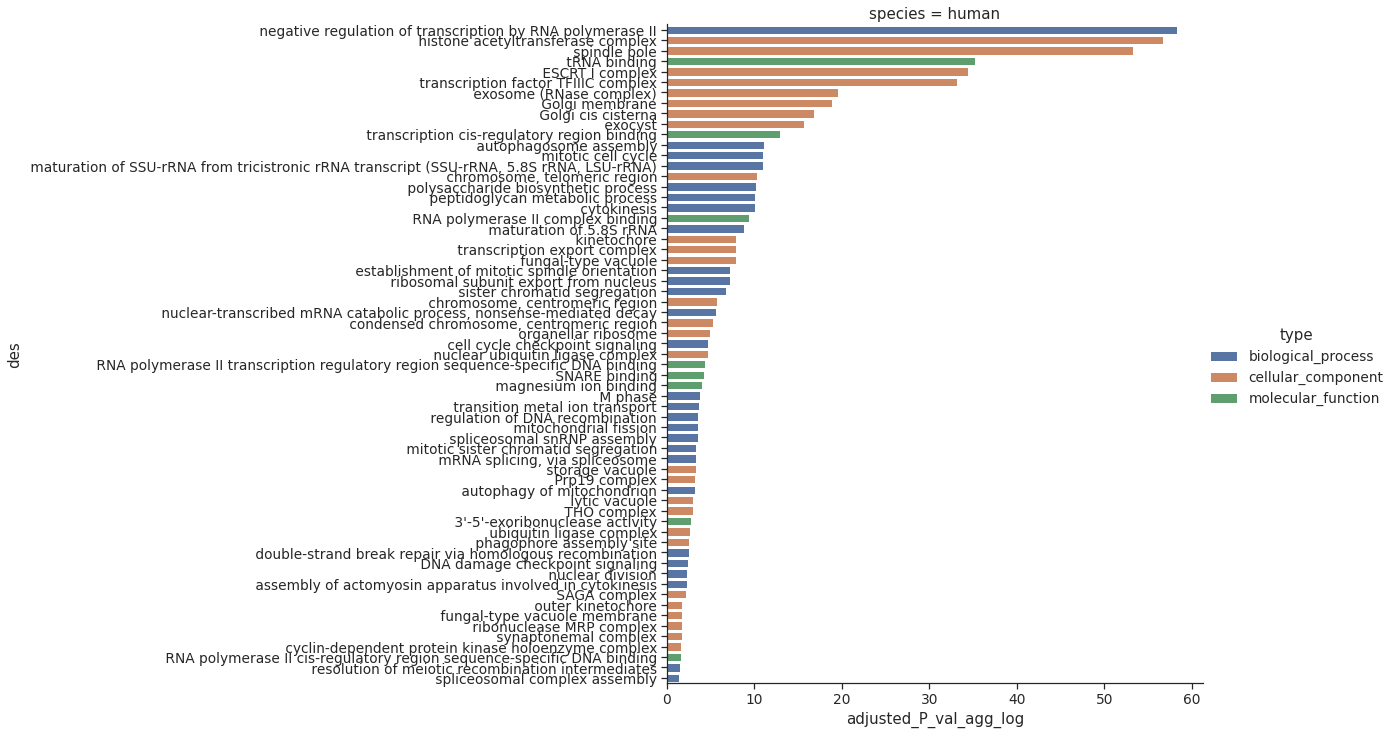

In [325]:
    df_whole = auc_GO_terms_manw_three_list_hic_exp[0]
    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]

    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] <= 0.05].sort_values(['adjusted_P_val_agg']), y='des', x='adjusted_P_val_agg_log', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species', hue='type')
    

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


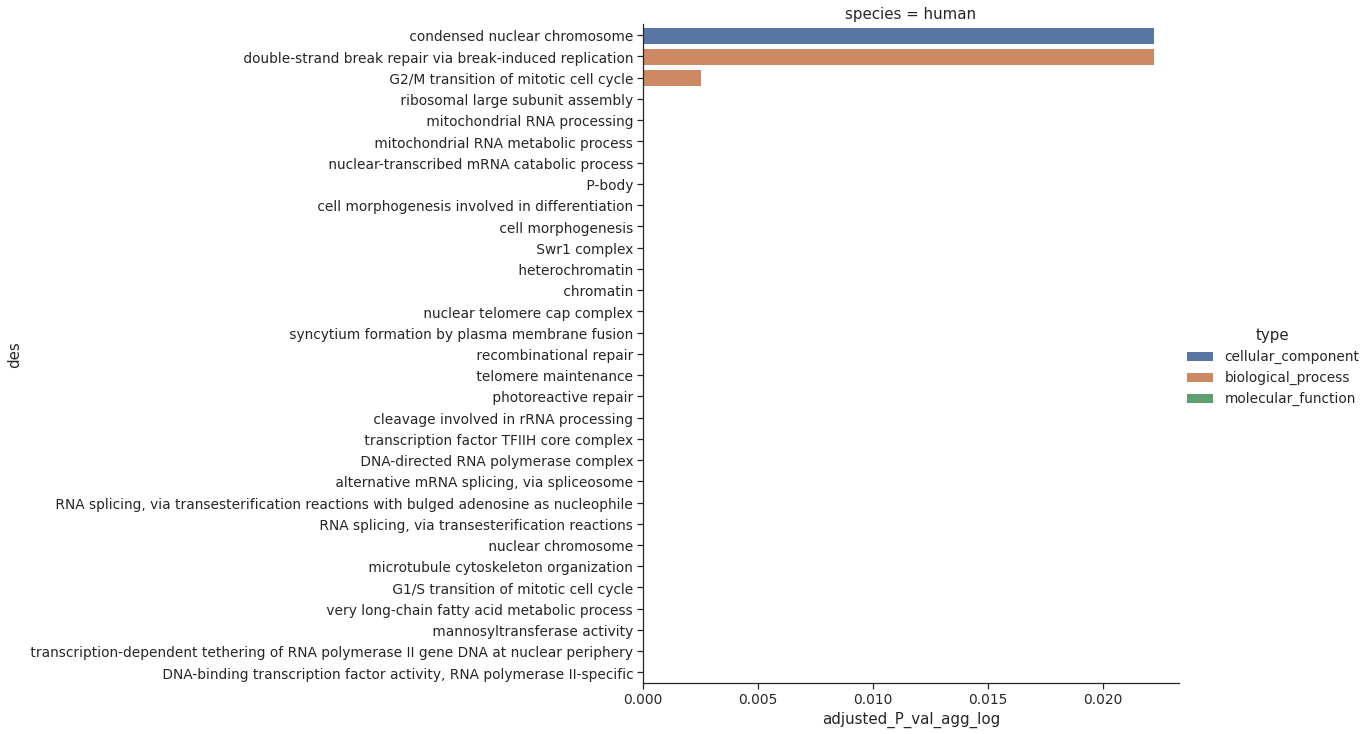

In [437]:
    df_whole = auc_GO_terms_manw_three_list_hic_exp[0]
    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]

    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] >= 0.95].sort_values(['adjusted_P_val_agg']), y='des', x='adjusted_P_val_agg_log', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species', hue='type')
    

In [438]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
auc_GO_terms_manw_three_list_hic_exp = []
for resolution in [100]:
    if species == 'drosophila':
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/1kbp_raw/max/inter_only/'
    else:
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}kbp_raw/max/'
    for fname in ['hic_gene_corr_inter_excluding_intra_nanranked_ind_1_percent_per_chr.csv']:
        
        df = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)

        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])


        #df_hic_auc = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/aggregates/10kbp_raw/max/inter_only/hic_gene_KR_inter_10_percent_per_chr_mouse_aggregates.csv', sep='\t')

        #df_hic_auc = pd.read_csv(f'{fpath}/{fname}', sep='\t')
        
        df_hic_auc = d2


        go_df_scores = go_table.merge(df_hic_auc, left_on=go_table.index, right_on='gene_id_exp_file')
        GO_groups = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther.txt', sep=" ", names=["del","go_id"])
        GO_groups_des = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_description.txt', sep=":", names=["del","des"])
        GO_groups_ben = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/aug4.GOslim', names=["go_id"])
        GO_groups_type = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_process.txt', sep=" ", names=["del","type"])




        from scipy.stats import mannwhitneyu
        import scipy.stats as stats
        z_list = []
        z_p_dict = []
        des_list = []
        for go_id in GO_groups["go_id"].tolist():
            
         if go_id in GO_groups_ben["go_id"].tolist():

            try:

                    t_p_scores = go_df_scores[go_df_scores[go_id] ==1 ]['auc'].tolist()

                    t_n_scores = go_df_scores[go_df_scores[go_id] ==0 ]['auc'].tolist()
                


                    U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
                    #nx, ny = len(t_p_scores), len(t_n_scores)
                    #N = nx + ny
                    #z = (U1 - nx*ny/2) / np.sqrt(nx*ny * (N + 1)/ 12)
                    #p = stats.norm.sf(z)
                    z_list.append(U1)
                    z_p_dict.append(p_val)

                    #print (p, p_val)
            except:
                print (go_id)
                z_list.append(np.nan)
                z_p_dict.append(np.nan)


        auc_GO_terms_manw = pd.DataFrame(list(zip(GO_groups["go_id"].tolist(),  z_p_dict , z_list, GO_groups_des['des'].tolist(), GO_groups_type['type'].tolist())), columns=['id', 'P_val_agg', 'U1_stat', 'des', 'type'])
        auc_GO_terms_manw['species'] = species
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)
        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        auc_GO_terms_manw.to_csv(f'{fpath}/GO_{fname}', sep='\t', index=False)
        auc_GO_terms_manw_three_list_hic_exp.append(auc_GO_terms_manw)


GO:0005618
GO:0009536
GO:0009579
GO:0015979


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


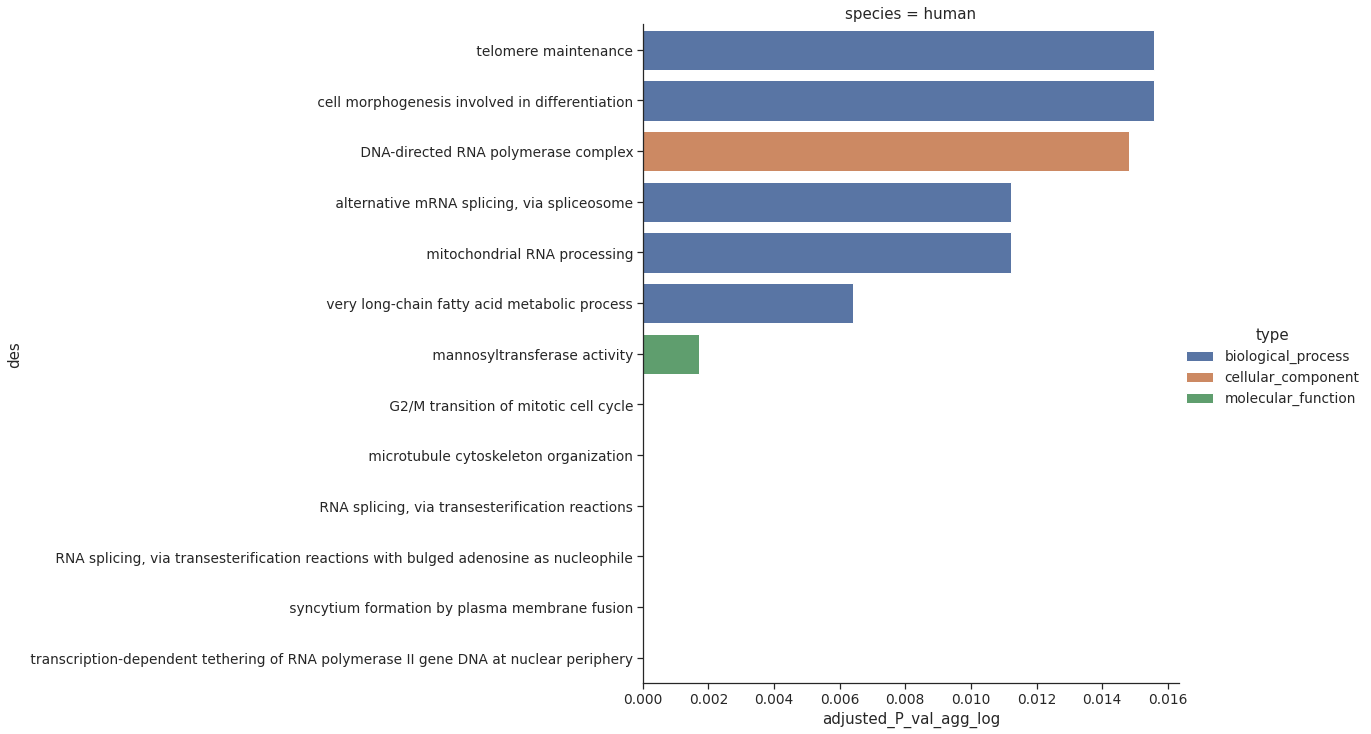

In [439]:
    df_whole = auc_GO_terms_manw_three_list_hic_exp[0]
    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]

    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] >= 0.95].sort_values(['adjusted_P_val_agg']), y='des', x='adjusted_P_val_agg_log', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species', hue='type')
    

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


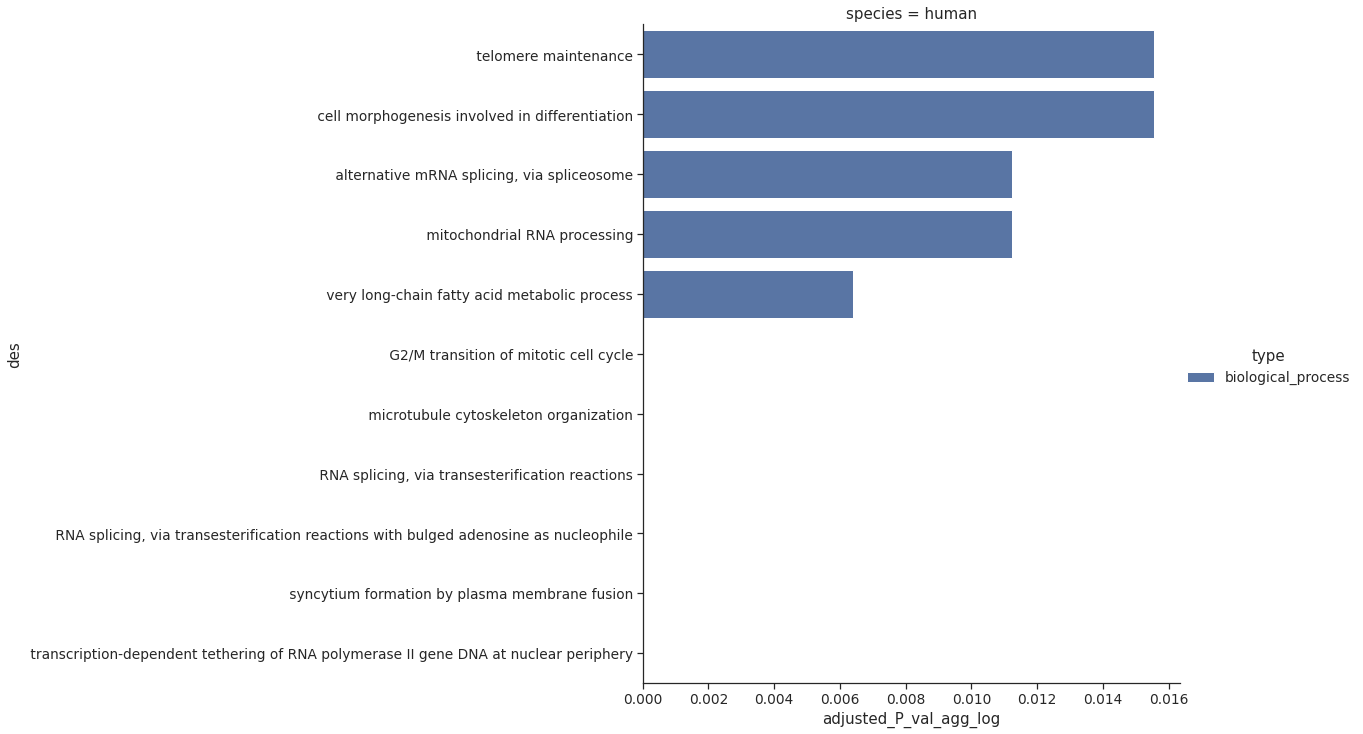

In [447]:
    df_whole = auc_GO_terms_manw_three_list_hic_exp[0]
    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]

    sns.catplot(data=df_whole[((df_whole['adjusted_P_val_agg'] > 0.95) & (df_whole['type'] == 'biological_process'))].sort_values(['adjusted_P_val_agg']), y='des', x='adjusted_P_val_agg_log', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species', hue='type')
    

In [349]:
df_de_prior = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/mc_predictability/pnas.1802973116.sd02.txt', sep='\t')



df_de_prior = df_ensg_name.merge(df_de_prior, left_on='Symbol', right_on='Gene_Name')

df_hic_de_prior = d2.merge(df_de_prior, left_on='gene_id_exp_file', right_on='Ensembl_gene_identifier' )

#sns.regplot(data=df1, y='DE_Prior_Rank', x='auc')


In [337]:
df_hic_de_prior

gene_id_exp_file    auc_de     GeneID Ensembl_gene_identifier  \
0      ENSG00000000419  0.912983       8813         ENSG00000000419   
1      ENSG00000000457  0.729834      57147         ENSG00000000457   
2      ENSG00000000460  0.651454      55732         ENSG00000000460   
3      ENSG00000000938  0.950337       2268         ENSG00000000938   
4      ENSG00000000971  0.592093       3075         ENSG00000000971   
...                ...       ...        ...                     ...   
16860  ENSG00000285219  0.617470  100506207         ENSG00000285219   
16861  ENSG00000285230  0.954593  101926888         ENSG00000285230   
16862  ENSG00000285294  0.754091     643650         ENSG00000285294   
16863  ENSG00000285331  0.776051     145783         ENSG00000285331   
16864  ENSG00000285347  0.891838     149684         ENSG00000285347   

             Symbol    type_of_gene  Gene_Order  Gene_EntrezID  N_HitLists  \
0              DPM1  protein-coding       14340           8813           7   
1             SCYL3  protein-coding       12706          57147           9   
2          C1orf112  protein-coding        4686          55732          21   
3               FGR  protein-coding        2663           2268          37   
4               CFH  protein-coding        1012           3075          53   
...             ...             ...         ...            ...         ...   
16860  LOC100506207           ncRNA       15329      100506207           5   
16861      RALY-AS1           ncRNA       11974      101926888           8   
16862     LINC00842           ncRNA       11775         643650           8   
16863     LOC145783           ncRNA       17403         145783           4   
16864     LOC149684           ncRNA       13562         149684           4   

       DE_Prior_Rank     Gene_Name  
0           0.252086          DPM1  
1           0.337289         SCYL3  
2           0.755659      C1orf112  
3           0.861230           FGR  
4           0.947293           CFH  
...              ...           ...  
16860       0.200449  LOC100506207  
16861       0.375496      RALY-AS1  
16862       0.385875     LINC00842  
16863       0.092192     LOC145783  
16864       0.292666     LOC149684  

[16865 rows x 11 columns]

<AxesSubplot:xlabel='quintile_DE_Prior_Rank', ylabel='auc_de'>

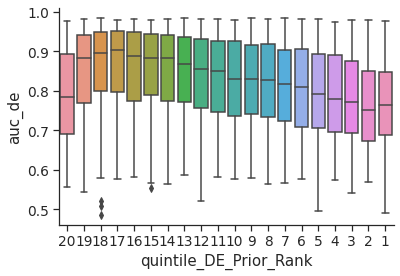

In [352]:
df_hic_de_prior['auc_d'] = df_hic_de_prior['auc_de'].round(1)
df_hic_de_prior['DE_Prior_Rank_d'] = df_hic_de_prior['DE_Prior_Rank'].round(1)
df_hic_de_prior['quintile_DE_Prior_Rank'] = pd.qcut(df_hic_de_prior['DE_Prior_Rank'] , 20, labels=np.arange(20, 0, -1))


sns.boxplot(data=df_hic_de_prior, x='quintile_DE_Prior_Rank', y='auc_de')



<AxesSubplot:xlabel='quintile_DE_Prior_Rank', ylabel='avg_rank'>

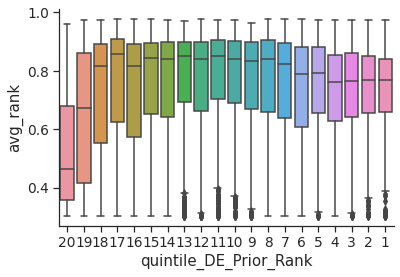

In [357]:
sns.boxplot(data=df_hic_de_prior, x='quintile_DE_Prior_Rank', y='avg_rank')

In [382]:
human_mouse_dn_ds = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/human_mouse_dn_ds.txt', sep='\t', names=['gene_id', '_g', 'dn', 'ds', '-', '--', '---', 'd'])



human_mouse_dn_ds = human_mouse_dn_ds.dropna(subset=['dn', 'ds'])

human_mouse_dn_ds['ratio'] = human_mouse_dn_ds['dn'] /  human_mouse_dn_ds['ds'] 

map_gene_uni = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene_ages/gene_to_uniprot_human.txt', sep='\t', names=['gene_id', 'uniprot_id'])

map_gene_uni.dropna(inplace=True)

map_gene_uni.drop_duplicates(inplace=True)
gene_age = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene_ages/main_HUMAN.csv')
uni_list = gene_age['Unnamed: 0'].tolist()

map_gene_uni = map_gene_uni[map_gene_uni['uniprot_id'].isin(uni_list)]

#map_gene_uni = map_gene_uni[map_gene_uni['gene_id'].isin(auc_values_1['gene_id_jac_sim'].tolist())]

map_gene_uni.drop_duplicates(subset='uniprot_id', inplace=True)
map_gene_uni.drop_duplicates(subset='gene_id', inplace=True)

df_con_age = map_gene_uni.merge(gene_age, left_on='uniprot_id', right_on='Unnamed: 0')

df_uni = df_con_age.merge(d2, left_on='gene_id', right_on=['gene_id_exp_file'])
dict_gene_age = {'Cellular_organisms':0, 'Euk_Archaea':1, 'Euk+Bac':2,'Eukaryota':3, 'Opisthokonta':4, 'Eumetazoa':5, 'Vertebrata':6, 'Mammalia':7}
df_uni['disc_age'] = [dict_gene_age[x] for x in df_uni['modeAge']]

df_auc_dn_ds = human_mouse_dn_ds.merge(d2, left_on='gene_id', right_on='gene_id_exp_file')


In [409]:
df_auc_dn_ds['ratio_d'] = ['pos' if x > 1 else 'neu' if x ==1 else 'neg' for x in df_auc_dn_ds['ratio']]

<AxesSubplot:xlabel='ratio_d', ylabel='auc_de'>

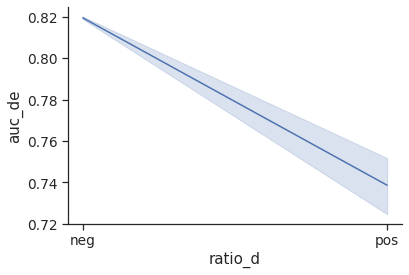

In [418]:
df_auc_dn_ds['auc_de_d'] = df_auc_dn_ds['auc_de'].round(1)
df_auc_dn_ds['quintile_ratio'] = pd.qcut(df_auc_dn_ds['ratio'] , 5, labels=np.arange(5, 0, -1))


sns.lineplot(data=df_auc_dn_ds, y='auc_de', x='ratio_d')

In [429]:
    t_p_scores = df_auc_dn_ds[df_auc_dn_ds['ratio_d'] =='pos' ]['auc'].tolist()
    t_n_scores = df_auc_dn_ds[df_auc_dn_ds['ratio_d'] =='neg' ]['auc'].tolist()
    U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='less')

In [430]:
 U1, p_val

(3437719.0, 1.659553831299281e-24)

<AxesSubplot:xlabel='disc_age', ylabel='auc'>

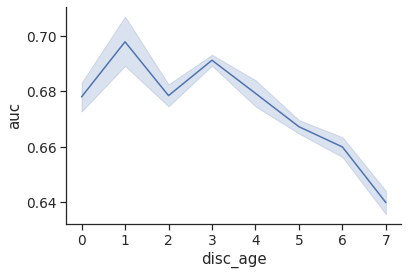

In [422]:
sns.lineplot(data=df_uni, y='auc', x='disc_age')

<AxesSubplot:xlabel='ratio_d', ylabel='auc'>

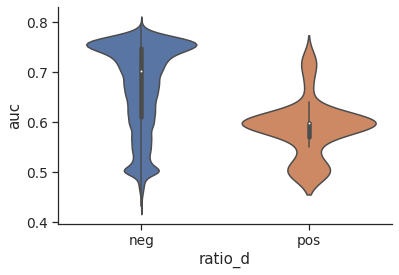

In [416]:

sns.violinplot(data=df_auc_dn_ds, y='auc', x='ratio_d')

<AxesSubplot:xlabel='quintile_ratio', ylabel='auc'>

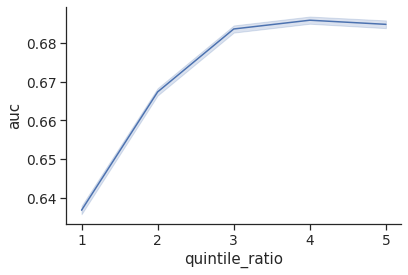

In [405]:

sns.lineplot(data=df_auc_dn_ds, y='auc', x='quintile_ratio')

<AxesSubplot:xlabel='quintile_ratio', ylabel='auc_de'>

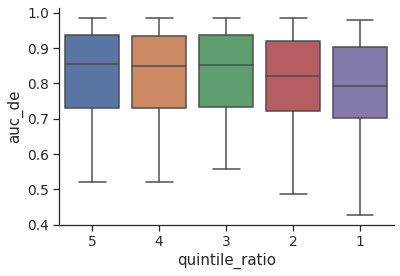

In [403]:
sns.boxplot(data=df_auc_dn_ds, y='auc_de', x='quintile_ratio')

In [388]:
df_auc_dn_ds

gene_id               _g      dn      ds                   -  \
0       ENSG00000142530  ENST00000593796  0.1211  1.0246  ENSMUSG00000051113   
1       ENSG00000142530  ENST00000600100  0.1211  1.0246  ENSMUSG00000051113   
2       ENSG00000142530  ENST00000602178  0.1211  1.0246  ENSMUSG00000051113   
3       ENSG00000142530  ENST00000595790  0.1211  1.0246  ENSMUSG00000051113   
4       ENSG00000142530  ENST00000599206  0.1211  1.0246  ENSMUSG00000051113   
...                 ...              ...     ...     ...                 ...   
150726  ENSG00000187735  ENST00000519704  0.0571  0.4468  ENSMUSG00000033813   
150727  ENSG00000187735  ENST00000640382  0.0571  0.4468  ENSMUSG00000033813   
150728  ENSG00000187735  ENST00000640041  0.0571  0.4468  ENSMUSG00000033813   
150729  ENSG00000187735  ENST00000640873  0.0571  0.4468  ENSMUSG00000033813   
150730  ENSG00000187735  ENST00000638322  0.0571  0.4468  ENSMUSG00000033813   

                        --    ---    d     ratio gene_id_exp_file    auc_de  \
0       ENSMUSP00000103560  100.0  0.0  0.118192  ENSG00000142530  0.958683   
1       ENSMUSP00000103560  100.0  0.0  0.118192  ENSG00000142530  0.958683   
2       ENSMUSP00000103560  100.0  0.0  0.118192  ENSG00000142530  0.958683   
3       ENSMUSP00000103560  100.0  0.0  0.118192  ENSG00000142530  0.958683   
4       ENSMUSP00000103560  100.0  0.0  0.118192  ENSG00000142530  0.958683   
...                    ...    ...  ...       ...              ...       ...   
150726  ENSMUSP00000129157  100.0  1.0  0.127798  ENSG00000187735  0.793038   
150727  ENSMUSP00000129157  100.0  1.0  0.127798  ENSG00000187735  0.793038   
150728  ENSMUSP00000129157  100.0  1.0  0.127798  ENSG00000187735  0.793038   
150729  ENSMUSP00000129157  100.0  1.0  0.127798  ENSG00000187735  0.793038   
150730  ENSMUSP00000129157  100.0  1.0  0.127798  ENSG00000187735  0.793038   

             auc            genes  avg_rank  auc_d  
0       0.738303  ENSG00000142530  0.622788    0.7  
1       0.738303  ENSG00000142530  0.622788    0.7  
2       0.738303  ENSG00000142530  0.622788    0.7  
3       0.738303  ENSG00000142530  0.622788    0.7  
4       0.738303  ENSG00000142530  0.622788    0.7  
...          ...              ...       ...    ...  
150726  0.682529  ENSG00000187735  0.931850    0.7  
150727  0.682529  ENSG00000187735  0.931850    0.7  
150728  0.682529  ENSG00000187735  0.931850    0.7  
150729  0.682529  ENSG00000187735  0.931850    0.7  
150730  0.682529  ENSG00000187735  0.931850    0.7  

[150731 rows x 15 columns]

In [364]:
df_essential_genes = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/HA_2014_essential.txt', sep='\t', names=['Symbol'])

df_ensg_name['essential'] = [1 if x in df_essential_genes['Symbol'].tolist() else 0 for x in df_ensg_name['Symbol']]


df_hk_genes = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/hk_genes/HK_genes.txt', sep='\t', names=['Symbol', '_id'])

df_hk_genes['Symbol'] = [x.strip() for x in df_hk_genes['Symbol'] ]

df_ensg_name['hk'] = [1 if x in df_hk_genes['Symbol'].tolist() else 0 for x in df_ensg_name['Symbol']]



cancer_genes = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/cancer_genes/cosmic_cancer.tsv', sep='\t')



df_ensg_name['cancer'] = [1 if x in cancer_genes['Gene Symbol'].tolist() else 0 for x in df_ensg_name['Symbol']]

df_rna_binding = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/rna_binding_proteins/41576_2014_BFnrg3813_MOESM25_ESM/RBP table-Table 1.tsv', sep='\t')



df_ensg_name['rna_binding'] = [1 if x in df_rna_binding['gene name'].tolist() else 0 for x in df_ensg_name['Symbol']]



In [365]:
df_ensg_name_hk = df_ensg_name.merge(d2, left_on =['Ensembl_gene_identifier'], right_on=['gene_id_exp_file'])


In [367]:
for property_type in ['essential', 'hk', 'rna_binding', 'cancer']:

    t_p_scores = df_ensg_name_hk[df_ensg_name_hk[property_type] ==1 ]['auc'].tolist()
    t_n_scores = df_ensg_name_hk[df_ensg_name_hk[property_type] ==0 ]['auc'].tolist()
    U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
    print (property_type, U1, p_val)

essential 6338838.0 3.3566248883470315e-36
hk 74695741.5 0.0
rna_binding 30362537.5 7.034763787283793e-128
cancer 13875513.5 6.390520950344434e-37


In [381]:
for property_type in ['essential', 'hk', 'rna_binding', 'cancer']:

    t_p_scores = df_ensg_name_hk[df_ensg_name_hk[property_type] ==1 ]['auc_de'].tolist()
    t_n_scores = df_ensg_name_hk[df_ensg_name_hk[property_type] ==0 ]['auc_de'].tolist()
    U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
    print (property_type, U1, p_val)

essential 5989696.0 5.269172377641438e-25
hk 68006779.0 1.2151254975112265e-243
rna_binding 28008381.5 4.9703403977321835e-67
cancer 11403938.5 0.006391698610802772


<AxesSubplot:xlabel='hk', ylabel='auc_de'>

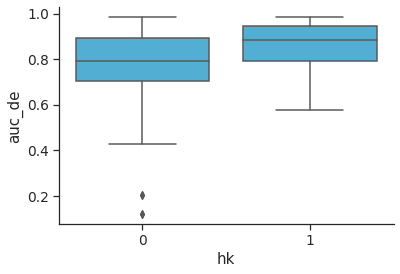

In [378]:
sns.boxplot(data=df_ensg_name_hk, x='hk', y='auc_de', palette=['#3CB7E8'])

<AxesSubplot:xlabel='disc_age', ylabel='auc'>

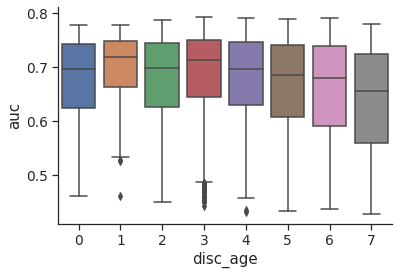

In [363]:
df_uni['auc_d'] = df_uni['auc'].round(1)

sns.boxplot(data=df_uni, y='auc', x='disc_age')

In [198]:
df1 = pd.DataFrame(list(zip(gene_ll, auc_ll)), columns =['gene_id_exp_file', 'auc_de'])



In [199]:
df2 = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/max/_totg_cre_auc_14.csv', sep='\t')

In [200]:
df = df1.merge(df2)


In [201]:
d2 = df.merge(exp_genes, left_on='gene_id_exp_file', right_on='genes')


In [508]:
d_g_depth = pd.read_csv('./gene_depth.csv')

In [512]:
d2_depth = d2.merge(d_g_depth, left_on='gene_id_exp_file', right_on='index')

In [553]:
d2_depth['quintile_rank'] = pd.qcut(d2_depth['avg_rank'] , 3, labels=np.arange(3, 0, -1))


d2_depth['quintile_score'] = pd.qcut(d2_depth['score'] , 10, labels=np.arange(10, 0, -1))

d2_depth['quintile_auc'] = pd.qcut(d2_depth['auc'] , 10, labels=np.arange(10, 0, -1))
d2_depth['quintile_auc'] = pd.qcut(d2_depth['auc'] , 10, labels=np.arange(10, 0, -1))


KeyboardInterrupt: 

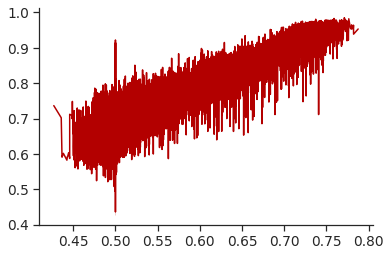

In [556]:
sns.lineplot(data=d2_depth, x='auc', y='auc_de', hue='quintile_rank',palette='hot', sort=True)

<AxesSubplot:xlabel='quintile_auc', ylabel='auc_de'>

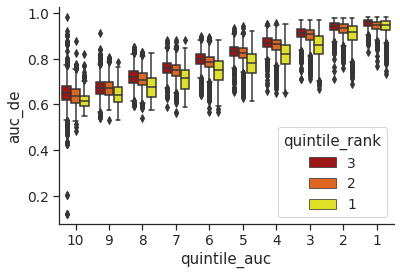

In [554]:
sns.boxplot(data=d2_depth, x='quintile_auc', y='auc_de', hue='quintile_rank',palette='hot')

<AxesSubplot:xlabel='quintile_auc', ylabel='auc_de'>

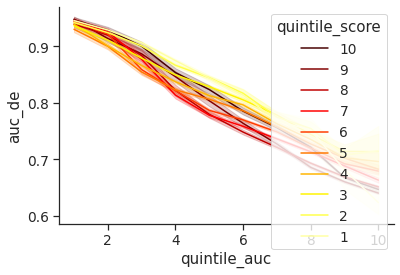

In [544]:
sns.lineplot(data=d2_depth, x='quintile_auc', y='auc_de', hue='quintile_score',palette='hot')

<AxesSubplot:xlabel='quintile_rank', ylabel='avg_rank'>

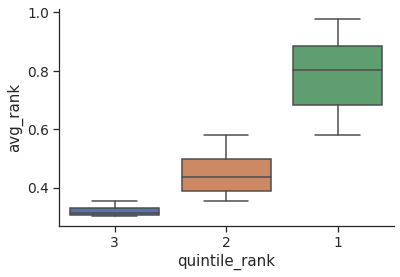

In [558]:
sns.boxplot(data=d2_depth, x='quintile_rank', y='avg_rank')

<AxesSubplot:xlabel='quintile_rank', ylabel='avg_rank'>

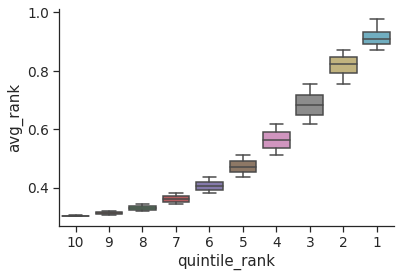

In [526]:
sns.boxplot(data=d2_depth, x='quintile_rank', y='avg_rank')

<AxesSubplot:xlabel='auc', ylabel='auc_de'>

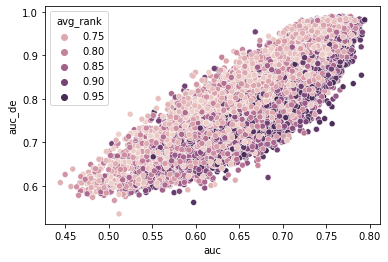

In [145]:
sns.scatterplot(y=d2['auc_de'], x=d2['auc'], hue=d2['avg_rank'])


<AxesSubplot:xlabel='auc', ylabel='auc_de'>

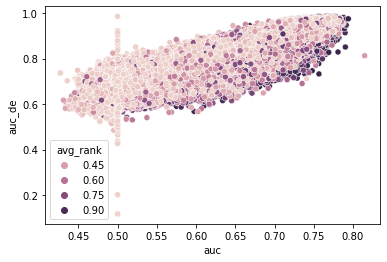

In [202]:
sns.scatterplot(y=d2['auc_de'], x=d2['auc'], hue=d2['avg_rank'])

In [146]:
!pwd

/grid/gillis/home/lohia/notebooks_proj2_marker_v2


In [582]:
ham1 = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/spe5_cls57_tau.csv')

df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['GeneID', 'Ensembl_gene_identifier', 'Symbol', 'type_of_gene']]



df_ensg_name = df_ensg_name.drop_duplicates(['Ensembl_gene_identifier', 'Symbol'])

df_ensg_name = df_ensg_name.drop_duplicates(['Ensembl_gene_identifier'])
df_ensg_name = df_ensg_name.drop_duplicates(['Symbol'])

df_ham_score = df_ensg_name.merge(ham1, left_on='Symbol', right_on='gene')

df_ham_score_d2 = df_ham_score.merge(d2_depth, left_on='Ensembl_gene_identifier', right_on='genes')

In [507]:
df_ham_score_d2

GeneID Ensembl_gene_identifier    Symbol    type_of_gene      gene  \
0              1         ENSG00000121410      A1BG  protein-coding      A1BG   
1             14         ENSG00000127837      AAMP  protein-coding      AAMP   
2             15         ENSG00000129673     AANAT  protein-coding     AANAT   
3             19         ENSG00000165029     ABCA1  protein-coding     ABCA1   
4             20         ENSG00000107331     ABCA2  protein-coding     ABCA2   
...          ...                     ...       ...             ...       ...   
13460  100652824         ENSG00000182329  KIAA2012  protein-coding  KIAA2012   
13461  100885848         ENSG00000267060   PTGES3L  protein-coding   PTGES3L   
13462  101060200         ENSG00000214029    ZNF891  protein-coding    ZNF891   
13463  101928601         ENSG00000269964      MEI4  protein-coding      MEI4   
13464  102157402         ENSG00000085231       AK6  protein-coding       AK6   

       human_counts  chimp_counts  gorilla_counts  rhesus_counts  \
0          0.797267      0.569239        0.847742       0.754078   
1          0.705299      0.392316        0.642104       0.536443   
2          0.753579      0.670573        0.938226       0.696160   
3          0.838253      0.615575        0.916065       0.622684   
4          0.899154      0.712586        0.900417       0.759737   
...             ...           ...             ...            ...   
13460      0.871327      0.827392        0.883115       0.876251   
13461      0.740163      0.790995        0.888304       0.866684   
13462      0.718339      0.460711        0.617857       0.413313   
13463      0.788059      0.479022        0.850576       0.577406   
13464      0.742798      0.346935        0.616554       0.370542   

       marmoset_counts  ...  marmoset_logcounts  gene_id_exp_file    auc_de  \
0             0.861490  ...            0.857958   ENSG00000121410  0.944279   
1             0.534037  ...            0.471692   ENSG00000127837  0.910183   
2             0.984183  ...            0.813062   ENSG00000129673  0.960232   
3             0.725229  ...            0.779072   ENSG00000165029  0.708920   
4             0.948100  ...            0.779529   ENSG00000107331  0.970551   
...                ...  ...                 ...               ...       ...   
13460         0.847562  ...            0.882986   ENSG00000182329  0.749145   
13461         0.877523  ...            0.826846   ENSG00000267060  0.953082   
13462         0.641676  ...            0.596141   ENSG00000214029  0.856701   
13463         0.801189  ...            0.739038   ENSG00000269964  0.564507   
13464         0.612994  ...            0.319229   ENSG00000085231  0.696712   

            auc            genes  avg_rank  quintile_rank  quintile_auc  \
0      0.729938  ENSG00000121410  0.612127              9             8   
1      0.758164  ENSG00000127837  0.924227              2             3   
2      0.761651  ENSG00000129673  0.623898              8             2   
3      0.626928  ENSG00000165029  0.900721              3            15   
4      0.766895  ENSG00000107331  0.904047              3             1   
...         ...              ...       ...            ...           ...   
13460  0.680189  ENSG00000182329  0.638703              8            12   
13461  0.750098  ENSG00000267060  0.670852              8             5   
13462  0.710695  ENSG00000214029  0.828691              6             9   
13463  0.469152  ENSG00000269964  0.520822              9            20   
13464  0.537353  ENSG00000085231  0.307587             10            19   

      quintile_human_logcounts  quintile_auc_de  
0                            2                1  
1                            3                2  
2                            2                1  
3                            2                5  
4                            1                1  
...                        ...              ...  
13460                        1  

In [584]:
df_ham_score_d2['quintile_rank'] = pd.qcut(df_ham_score_d2['avg_rank'] , 10, labels=np.arange(10, 0, -1))


In [236]:
df_ham_score_d2_high_exp = df_ham_score_d2[df_ham_score_d2['avg_rank'] > 0.7]

In [237]:
df_ham_score_d2_high_exp['quintile_rank'] = pd.qcut(df_ham_score_d2_high_exp['avg_rank'] , 2, labels=np.arange(2, 0, -1))


<ipython-input-237-b8df8133cf74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ham_score_d2_high_exp['quintile_rank'] = pd.qcut(df_ham_score_d2_high_exp['avg_rank'] , 2, labels=np.arange(2, 0, -1))


In [585]:
df_ham_score_d2['quintile_auc'] = pd.qcut(df_ham_score_d2['auc'] , 10, labels=np.arange(10, 0, -1))

In [586]:
df_ham_score_d2['quintile_auc_de'] = pd.qcut(df_ham_score_d2['auc_de'] , 5, labels=np.arange(5, 0, -1))

In [591]:
df_ham_score_d2['quintile_score'] = pd.qcut(df_ham_score_d2['score'] , 10, labels=np.arange(10, 0, -1))

In [603]:
df_ham_score_d2['quintile_human_logcounts'] = pd.qcut(df_ham_score_d2['human_logcounts'] , 2, labels=np.arange(2, 0, -1))


<AxesSubplot:xlabel='avg_rank', ylabel='human_logcounts'>

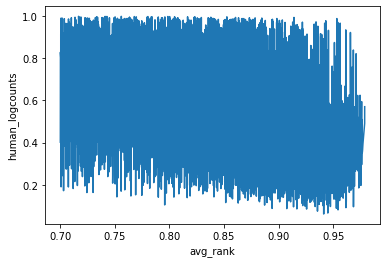

In [169]:
sns.lineplot(data=df_ham_score_d2, x='avg_rank', y='human_logcounts')

<AxesSubplot:xlabel='quintile_human_logcounts', ylabel='auc'>

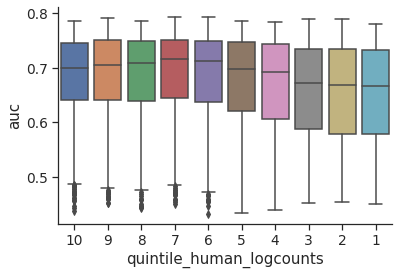

In [563]:
sns.boxplot(data=df_ham_score_d2, x='quintile_human_logcounts', y='auc')

<AxesSubplot:xlabel='quintile_human_logcounts', ylabel='auc_de'>

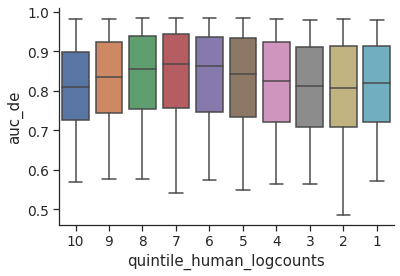

In [562]:
sns.boxplot(data=df_ham_score_d2, x='quintile_human_logcounts', y='auc_de')

<AxesSubplot:xlabel='quintile_rank', ylabel='auc'>

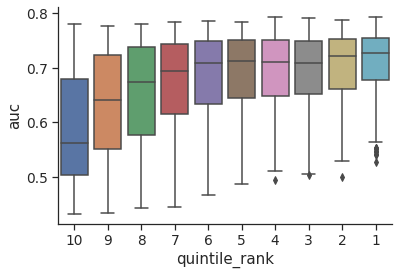

In [505]:
sns.boxplot(data=df_ham_score_d2, x='quintile_rank', y='auc')

<AxesSubplot:xlabel='quintile_human_logcounts', ylabel='auc'>

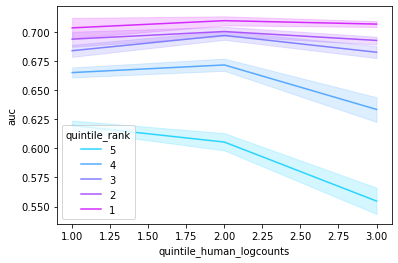

In [301]:
sns.lineplot(data=df_ham_score_d2, x='quintile_human_logcounts', y='auc', hue='quintile_rank', palette='cool')

<AxesSubplot:xlabel='quintile_human_logcounts', ylabel='auc'>

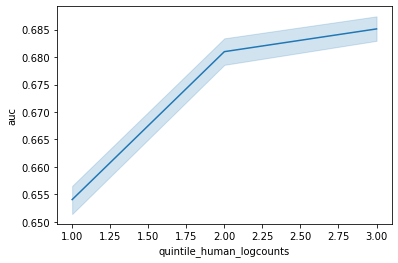

In [303]:
sns.lineplot(data=df_ham_score_d2, x='quintile_human_logcounts', y='auc')

<AxesSubplot:xlabel='quintile_human_logcounts', ylabel='auc_de'>

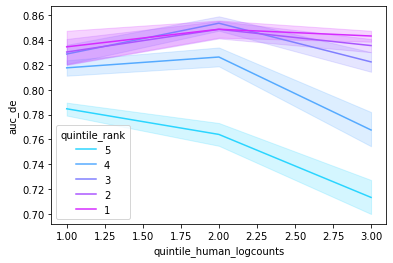

In [304]:
sns.lineplot(data=df_ham_score_d2, x='quintile_human_logcounts', y='auc_de', hue='quintile_rank', palette='cool')

<AxesSubplot:xlabel='quintile_rank', ylabel='auc'>

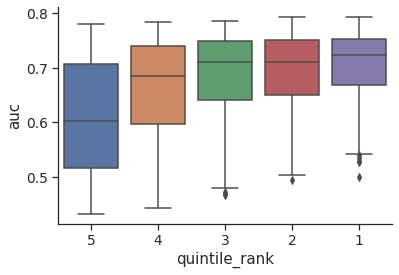

In [449]:
sns.boxplot(data=df_ham_score_d2, x='quintile_rank', y='auc_de')

<AxesSubplot:xlabel='quintile_rank', ylabel='human_logcounts'>

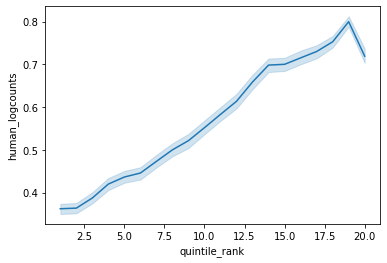

In [278]:
sns.lineplot(data=df_ham_score_d2, x='quintile_rank', y='human_logcounts')

<AxesSubplot:xlabel='quintile_rank', ylabel='avg_rank'>

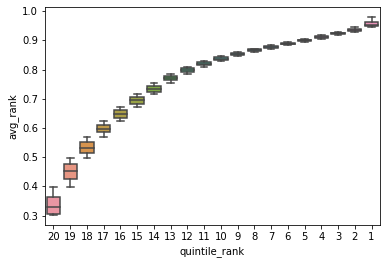

In [289]:
sns.boxplot(data=df_ham_score_d2, x='quintile_rank', y='avg_rank')

<AxesSubplot:xlabel='auc', ylabel='auc_de'>

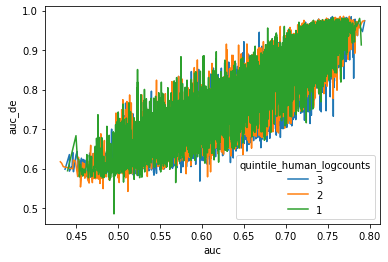

In [288]:
sns.lineplot(data=df_ham_score_d2, x='auc', y='auc_de', hue='quintile_human_logcounts')

<AxesSubplot:xlabel='quintile_rank', ylabel='human_logcounts'>

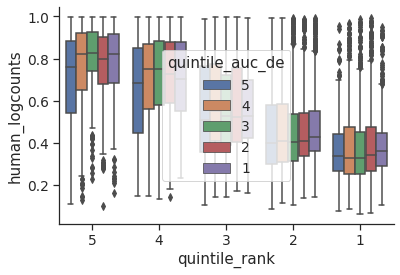

In [456]:
sns.boxplot(data=df_ham_score_d2,x='quintile_rank', y='human_logcounts', hue='quintile_auc_de')

<AxesSubplot:xlabel='quintile_auc', ylabel='auc_de'>

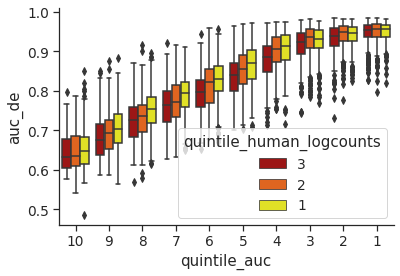

In [588]:

sns.boxplot(data=df_ham_score_d2, x='quintile_auc', y='auc_de', hue='quintile_human_logcounts',palette='hot')



<AxesSubplot:xlabel='quintile_score', ylabel='auc'>

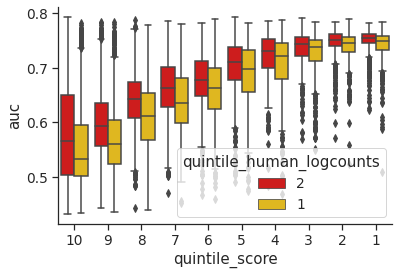

In [604]:
sns.boxplot(data=df_ham_score_d2, x='quintile_score', y='auc', hue='quintile_human_logcounts',palette='hot')



<AxesSubplot:xlabel='quintile_score', ylabel='auc_de'>

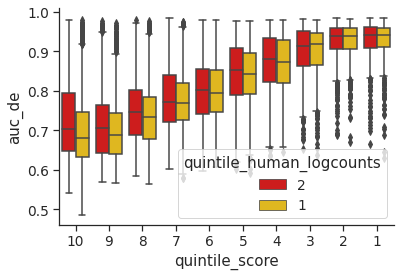

In [605]:
sns.boxplot(data=df_ham_score_d2, x='quintile_score', y='auc_de', hue='quintile_human_logcounts',palette='hot')



<AxesSubplot:xlabel='quintile_score', ylabel='auc_de'>

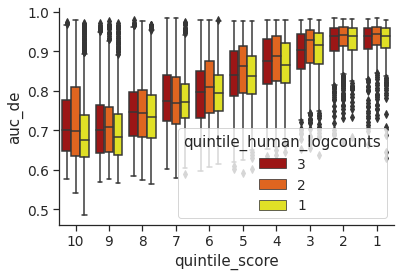

In [597]:
sns.boxplot(data=df_ham_score_d2, x='quintile_score', y='auc_de', hue='quintile_human_logcounts',palette='hot')



In [581]:
df_ham_score_d2['score']

KeyError: 'score'

<AxesSubplot:xlabel='quintile_auc', ylabel='auc_de'>

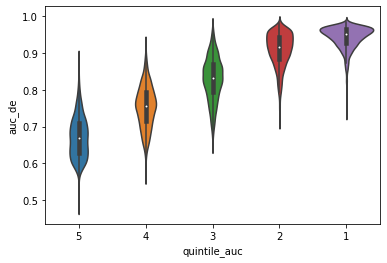

In [218]:
sns.violinplot(data=df_ham_score_d2, x='quintile_auc', y='auc_de')

In [216]:
df_ham_score_d2

GeneID Ensembl_gene_identifier    Symbol    type_of_gene      gene  \
0              1         ENSG00000121410      A1BG  protein-coding      A1BG   
1             14         ENSG00000127837      AAMP  protein-coding      AAMP   
2             15         ENSG00000129673     AANAT  protein-coding     AANAT   
3             19         ENSG00000165029     ABCA1  protein-coding     ABCA1   
4             20         ENSG00000107331     ABCA2  protein-coding     ABCA2   
...          ...                     ...       ...             ...       ...   
13460  100652824         ENSG00000182329  KIAA2012  protein-coding  KIAA2012   
13461  100885848         ENSG00000267060   PTGES3L  protein-coding   PTGES3L   
13462  101060200         ENSG00000214029    ZNF891  protein-coding    ZNF891   
13463  101928601         ENSG00000269964      MEI4  protein-coding      MEI4   
13464  102157402         ENSG00000085231       AK6  protein-coding       AK6   

       human_counts  chimp_counts  gorilla_counts  rhesus_counts  \
0          0.797267      0.569239        0.847742       0.754078   
1          0.705299      0.392316        0.642104       0.536443   
2          0.753579      0.670573        0.938226       0.696160   
3          0.838253      0.615575        0.916065       0.622684   
4          0.899154      0.712586        0.900417       0.759737   
...             ...           ...             ...            ...   
13460      0.871327      0.827392        0.883115       0.876251   
13461      0.740163      0.790995        0.888304       0.866684   
13462      0.718339      0.460711        0.617857       0.413313   
13463      0.788059      0.479022        0.850576       0.577406   
13464      0.742798      0.346935        0.616554       0.370542   

       marmoset_counts  ...  rhesus_logcounts  marmoset_logcounts  \
0             0.861490  ...          0.857422            0.857958   
1             0.534037  ...          0.478244            0.471692   
2             0.984183  ...          0.849363            0.813062   
3             0.725229  ...          0.811849            0.779072   
4             0.948100  ...          0.831991            0.779529   
...                ...  ...               ...                 ...   
13460         0.847562  ...          0.903217            0.882986   
13461         0.877523  ...          0.798022            0.826846   
13462         0.641676  ...          0.615908            0.596141   
13463         0.801189  ...          0.764276            0.739038   
13464         0.612994  ...          0.329814            0.319229   

       gene_id_exp_file    auc_de       auc            genes  avg_rank  \
0       ENSG00000121410  0.944279  0.729938  ENSG00000121410  0.612127   
1       ENSG00000127837  0.910183  0.758164  ENSG00000127837  0.924227   
2       ENSG00000129673  0.960232  0.761651  ENSG00000129673  0.623898   
3       ENSG00000165029  0.708920  0.626928  ENSG00000165029  0.900721   
4       ENSG00000107331  0.970551  0.766895  ENSG00000107331  0.904047   
...                 ...       ...       ...              ...       ...   
13460   ENSG00000182329  0.749145  0.680189  ENSG00000182329  0.638703   
13461   ENSG00000267060  0.953082  0.750098  ENSG00000267060  0.670852   
13462   ENSG00000214029  0.856701  0.710695  ENSG00000214029  0.828691   
13463   ENSG00000269964  0.564507  0.469152  ENSG00000269964  0.520822   
13464   ENSG00000085231  0.696712  0.537353  ENSG00000085231  0.307587   

       quintile_rank quintile_auc  quintile_human_logcounts  
0                  5            2                         4  
1                  1            1                         9  
2                  4            1                         5  
3                  2            4                         4  
4                  2            1                         3  
...              ...          ...                       ...  
13460              4            3                         2  
13461             

<AxesSubplot:xlabel='auc_de', ylabel='human_logcounts'>

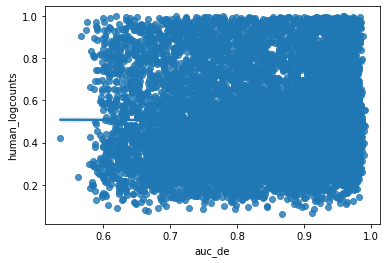

In [166]:
sns.regplot(data=df_ham_score_d2, x='auc_de', y='human_logcounts')

<AxesSubplot:xlabel='auc_de', ylabel='auc'>

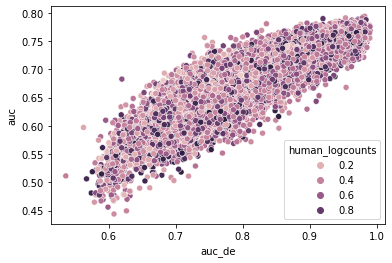

In [168]:
sns.scatterplot(data=df_ham_score_d2, x='auc_de', y='auc', hue='human_logcounts')

<AxesSubplot:xlabel='auc', ylabel='auc_de'>

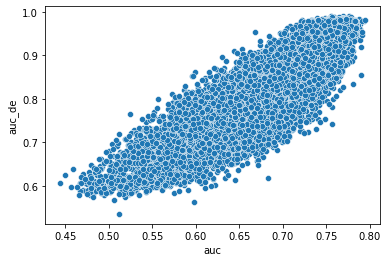

In [106]:
sns.scatterplot(y=d2['auc_de'], x=d2['auc'])



In [144]:
ax = sns.polyplot(data=d2[d2['avg_rank']>0.9], y='auc_de', x='auc')

ax.set_xlim([0.45,1])
ax.set_ylim([0.45,1])

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, '-r')


AttributeError: module 'seaborn' has no attribute 'polyplot'

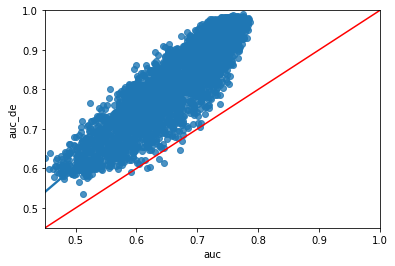

In [143]:
ax = sns.regplot(data=d2[d2['avg_rank']<0.8], y='auc_de', x='auc')

ax.set_xlim([0.45,1])
ax.set_ylim([0.45,1])

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, '-r')

In [137]:
lims

[0.45, 0.8]

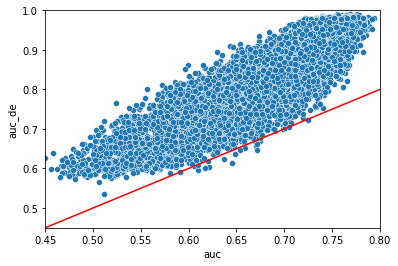

In [132]:
ax = sns.scatterplot(data=d2[(d2['avg_rank']<0.9 )], y='auc_de', x='auc')
ax.set_xlim([0.45,0.8])
ax.set_ylim([0.45,1])
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, '-r')


<AxesSubplot:xlabel='auc', ylabel='auc_de'>

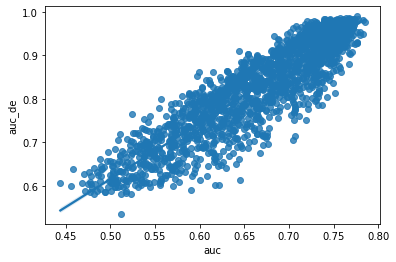

In [104]:
sns.regplot(data=d2[d2['avg_rank']<0.75], y='auc_de', x='auc')

<AxesSubplot:xlabel='avg_rank', ylabel='auc'>

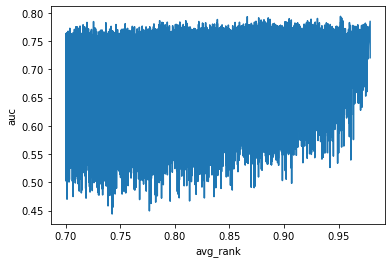

In [96]:
sns.lineplot(y=d2['auc'], x=d2['avg_rank'])

In [88]:
exp_genes

genes  avg_rank
0      ENSG00000223972  0.443509
1      ENSG00000227232  0.733437
2      ENSG00000278267  0.548917
3      ENSG00000243485  0.397697
4      ENSG00000284332  0.301684
...                ...       ...
64480  ENSG00000276017  0.321917
64481  ENSG00000278817  0.649758
64482  ENSG00000277196  0.612010
64483  ENSG00000278625  0.314648
64484  ENSG00000277374  0.302087

[64440 rows x 2 columns]

<AxesSubplot:xlabel='auc', ylabel='auc_de'>

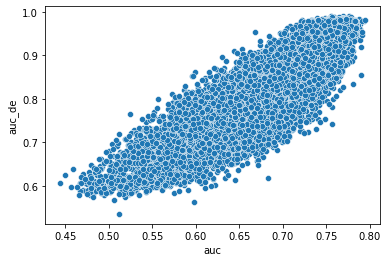

In [41]:
sns.scatterplot(y=df['auc_de'], x=df['auc'])

<AxesSubplot:xlabel='auc', ylabel='auc_de'>

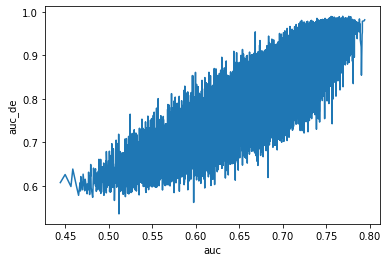

In [44]:
sns.lineplot(y=df['auc_de'], x=df['auc'])

In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
auc_GO_terms_manw_three_list_hic_exp = []
for resolution in [100]:
    if species == 'drosophila':
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/1kbp_raw/max/inter_only/'
    else:
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}kbp_raw/max/'
    for fname in ['hic_gene_corr_inter_excluding_intra_nanranked_ind_1_percent_per_chr.csv']:
        
        df = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)

        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])


        #df_hic_auc = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/aggregates/10kbp_raw/max/inter_only/hic_gene_KR_inter_10_percent_per_chr_mouse_aggregates.csv', sep='\t')

        #df_hic_auc = pd.read_csv(f'{fpath}/{fname}', sep='\t')
        
        df_hic_auc = df2


        go_df_scores = go_table.merge(df_hic_auc, left_on=go_table.index, right_on='gene_id_exp_file')
        GO_groups = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther.txt', sep=" ", names=["del","go_id"])
        GO_groups_des = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_description.txt', sep=":", names=["del","des"])
        GO_groups_ben = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/aug4.GOslim', names=["go_id"])
        GO_groups_type = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_process.txt', sep=" ", names=["del","type"])




        from scipy.stats import mannwhitneyu
        import scipy.stats as stats
        z_list = []
        z_p_dict = []
        des_list = []
        for go_id in GO_groups["go_id"].tolist():
            
         if go_id in GO_groups_ben["go_id"].tolist():

            try:

                    t_p_scores = go_df_scores[go_df_scores[go_id] ==1 ]['auc'].tolist()

                    t_n_scores = go_df_scores[go_df_scores[go_id] ==0 ]['auc'].tolist()
                


                    U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
                    #nx, ny = len(t_p_scores), len(t_n_scores)
                    #N = nx + ny
                    #z = (U1 - nx*ny/2) / np.sqrt(nx*ny * (N + 1)/ 12)
                    #p = stats.norm.sf(z)
                    z_list.append(U1)
                    z_p_dict.append(p_val)

                    #print (p, p_val)
            except:
                print (go_id)
                z_list.append(np.nan)
                z_p_dict.append(np.nan)


        auc_GO_terms_manw = pd.DataFrame(list(zip(GO_groups["go_id"].tolist(),  z_p_dict , z_list, GO_groups_des['des'].tolist(), GO_groups_type['type'].tolist())), columns=['id', 'P_val_agg', 'U1_stat', 'des', 'type'])
        auc_GO_terms_manw['species'] = species
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)
        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        auc_GO_terms_manw.to_csv(f'{fpath}/GO_{fname}', sep='\t', index=False)
        auc_GO_terms_manw_three_list_hic_exp.append(auc_GO_terms_manw)


GO:0005618
GO:0009536
GO:0009579
GO:0015979


In [48]:
go_df_scores

GO:0000002  GO:0000003  GO:0000009  GO:0000010  GO:0000012  GO:0000014  \
0             0.0         0.0         0.0         0.0         0.0         0.0   
1             0.0         0.0         0.0         0.0         0.0         0.0   
2             0.0         0.0         0.0         0.0         0.0         0.0   
3             0.0         0.0         0.0         0.0         0.0         0.0   
4             0.0         0.0         0.0         0.0         0.0         0.0   
...           ...         ...         ...         ...         ...         ...   
20032         0.0         0.0         0.0         0.0         0.0         0.0   
20033         0.0         0.0         0.0         0.0         0.0         0.0   
20034         0.0         0.0         0.0         0.0         0.0         0.0   
20035         0.0         0.0         0.0         0.0         0.0         0.0   
20036         0.0         0.0         0.0         0.0         0.0         0.0   

       GO:0000015  GO:0000016  GO:0000017  GO:0000018  ...  GO:2001295  \
0             0.0         0.0         0.0         0.0  ...         0.0   
1             0.0         0.0         0.0         0.0  ...         0.0   
2             0.0         0.0         0.0         0.0  ...         0.0   
3             0.0         0.0         0.0         0.0  ...         0.0   
4             0.0         0.0         0.0         0.0  ...         0.0   
...           ...         ...         ...         ...  ...         ...   
20032         0.0         0.0         0.0         0.0  ...         0.0   
20033         0.0         0.0         0.0         0.0  ...         0.0   
20034         0.0         0.0         0.0         0.0  ...         0.0   
20035         0.0         0.0         0.0         0.0  ...         0.0   
20036         0.0         0.0         0.0         0.0  ...         0.0   

       GO:2001300  GO:2001301  GO:2001302  GO:2001303  GO:2001304  GO:2001306  \
0             0.0         0.0         0.0         0.0         0.0         0.0   
1             0.0         0.0         0.0         0.0         0.0         0.0   
2             0.0         0.0         0.0         0.0         0.0         0.0   
3             0.0         0.0         0.0         0.0         0.0         0.0   
4             0.0         0.0         0.0         0.0         0.0         0.0   
...           ...         ...         ...         ...         ...         ...   
20032         0.0         0.0         0.0         0.0         0.0         0.0   
20033         0.0         0.0         0.0         0.0         0.0         0.0   
20034         0.0         0.0         0.0         0.0         0.0         0.0   
20035         0.0         0.0         0.0         0.0         0.0         0.0   
20036         0.0         0.0         0.0         0.0         0.0         0.0   

       GO:2001311  gene_id_exp_file       auc  
0             0.0   ENSG00000000419  0.743154  
1             0.0   ENSG00000000457  0.599157  
2             0.0   ENSG00000000460  0.585266  
3             0.0   ENSG00000000938  0.757391  
4             0.0   ENSG00000000971  0.489380  
...           ...               ...       ...  
20032         0.0   ENSG00000285472  0.497687  
20033         0.0   ENSG00000285480  0.734792  
20034         0.0   ENSG00000285505  0.748928  
20035         0.0   ENSG00000285508  0.668269  
20036         0.0   ENSG00000285509  0.655929  

[20037 rows x 22928 columns]

In [46]:
df_hic_auc

gene_id_exp_file       auc
0      ENSG00000000419  0.743154
1      ENSG00000000457  0.599157
2      ENSG00000000460  0.585266
3      ENSG00000000938  0.757391
4      ENSG00000000971  0.489380
...                ...       ...
55406  ENSG00000285498  0.509631
55407  ENSG00000285505  0.748928
55408  ENSG00000285508  0.668269
55409  ENSG00000285509  0.655929
55410  ENSG00000285513  0.678984

[55411 rows x 2 columns]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


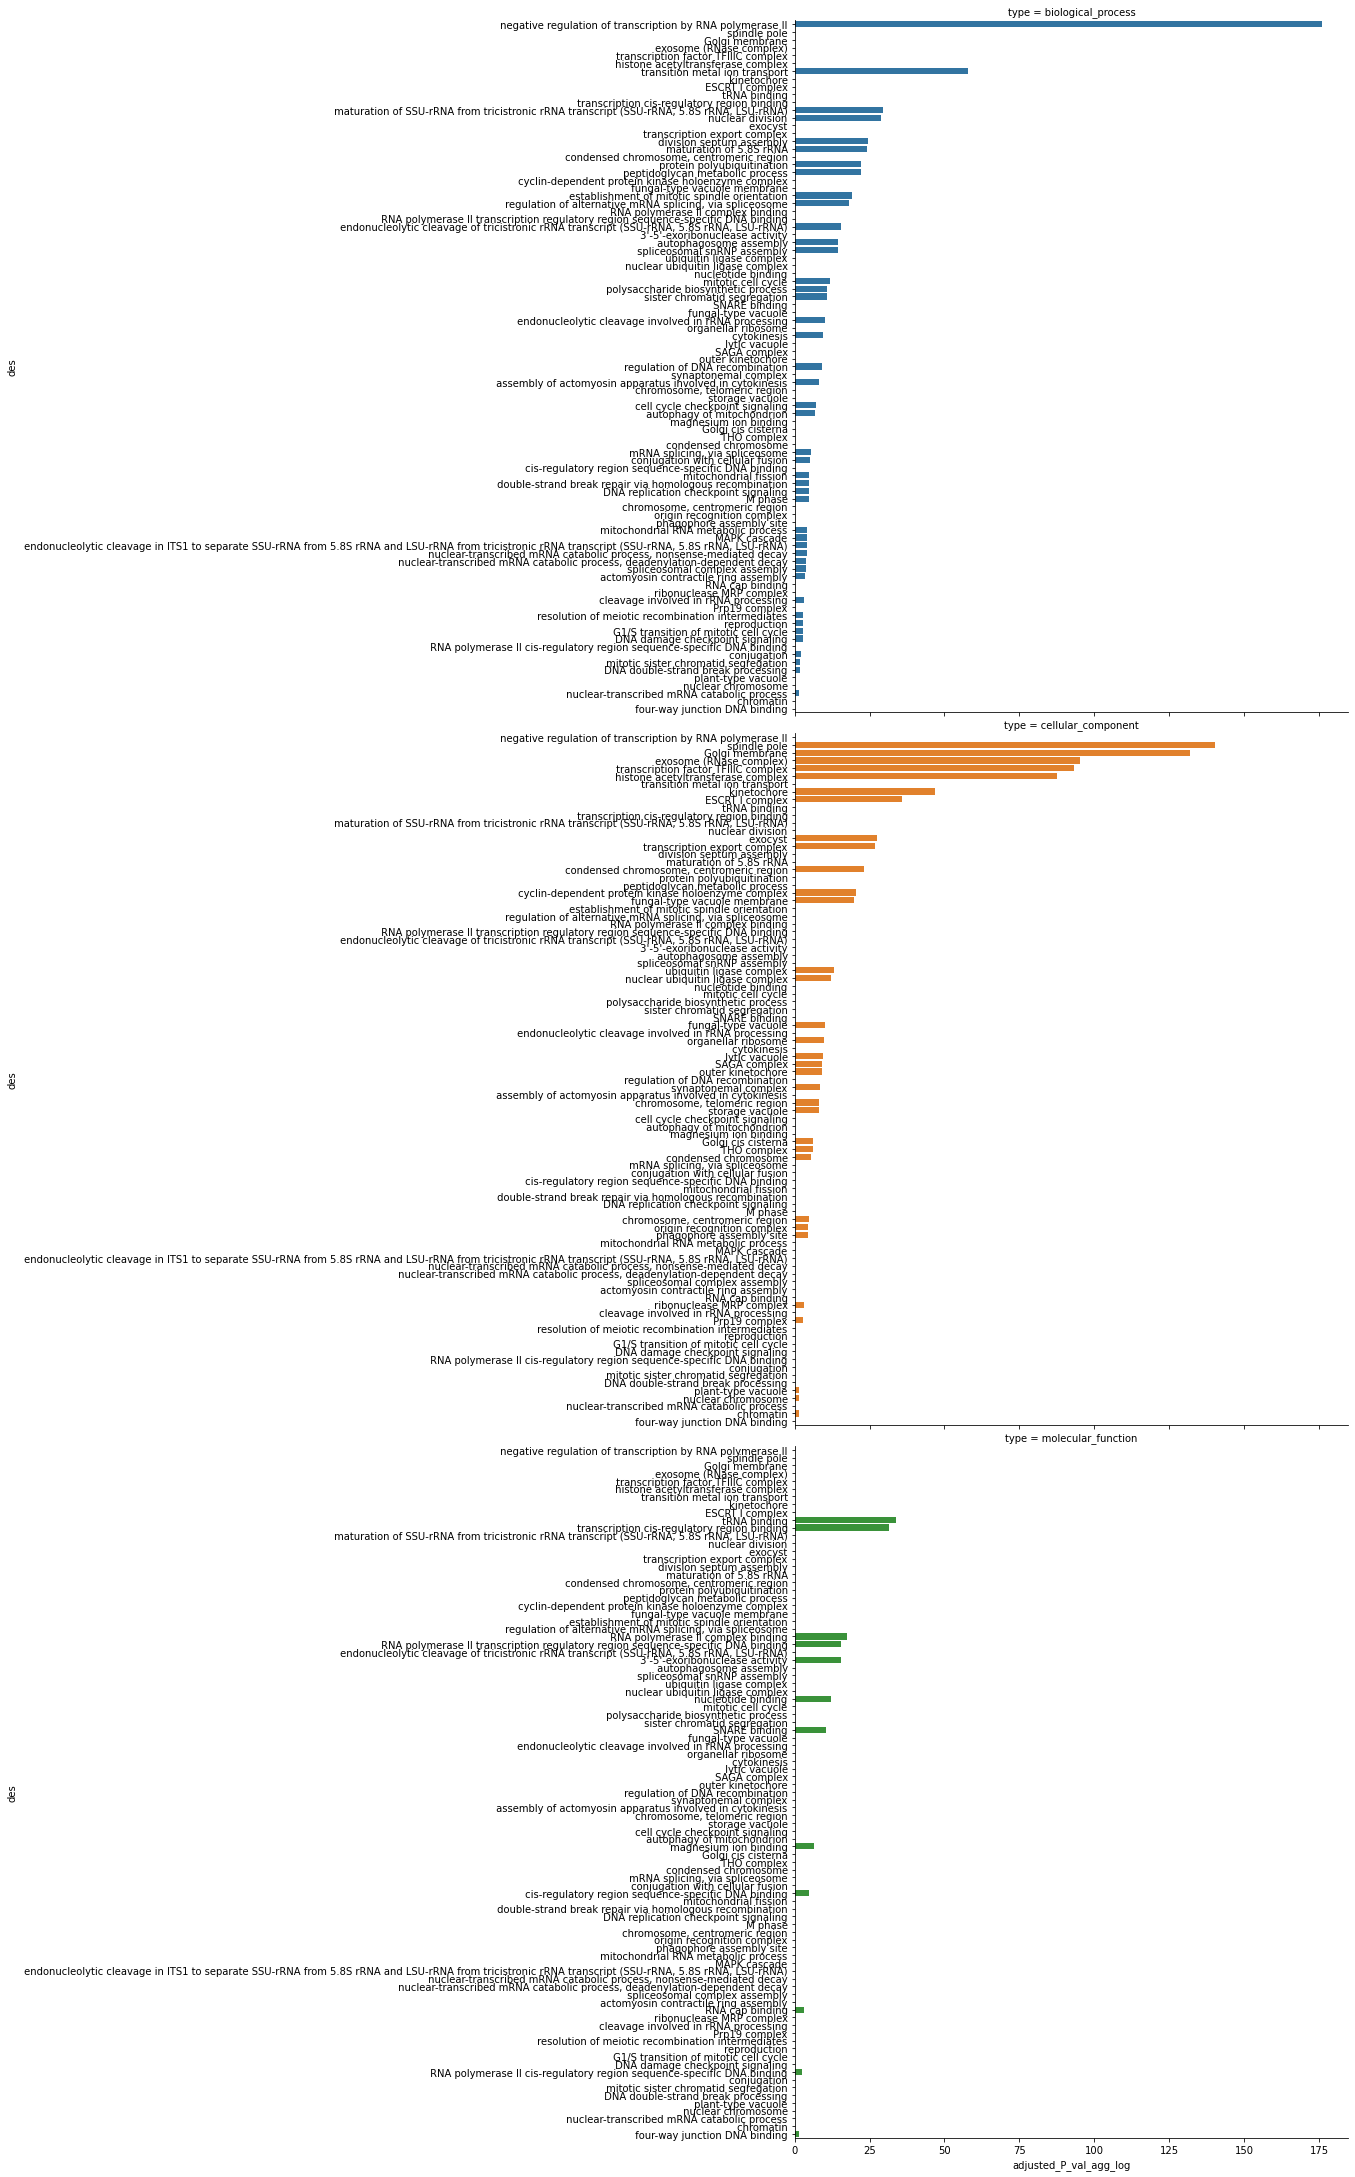

In [53]:
df_whole = auc_GO_terms_manw_three_list_hic_exp[0]
df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]

sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] <= 0.05].sort_values(['adjusted_P_val_agg']), y='des', x='adjusted_P_val_agg_log', height=10, aspect=8/9.5, kind='bar', dodge=False, row='type', hue='type')
    

In [ ]:
df_whole = auc_GO_terms_manw_three_list_hic_exp[0]
df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]

sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] <= 0.05].sort_values(['adjusted_P_val_agg']), y='des', x='adjusted_P_val_agg_log', height=10, aspect=8/9.5, kind='bar', dodge=False, row='type', hue='type')
    

In [56]:
resolution_human = 10000
species = "human"
SRP_name = "aggregates"
resolution = "10kbp_raw"



input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])


In [57]:
    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    else:

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

In [60]:
cre_bins = df_cre_1kb_encode[df_cre_1kb_encode['cre']>14]['bin_id'].tolist()


In [61]:
df_gene_tp_sel_cre = df_gene_tp_sel[cre_bins]

In [63]:
df_2d_jac, go_chrom  = run_egad(df_gene_tp_sel_cre, df_exp_corr)

(13157, 13157)
(13157, 8342)
0.9693905994526353
0.0


<ipython-input-3-245e0933ef6b>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


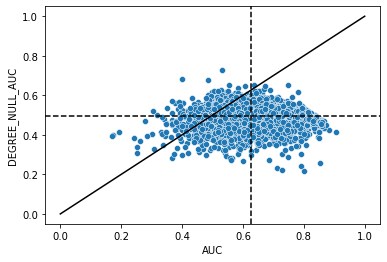

In [64]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [65]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import pandas as pd

def fishers_exact(TP, TN, FP, FN):
    """Fishers exact for enrichment
	
	Input are values from a contigency tables
	
	Arguments:
		TP {int} -- Size of overlap
		TN {int} -- Size of both negative
		FP {int} -- Size of False Positive (Selected but not in query)
		FN {int} -- Size of False Negative (Not selected but in query)
	"""
    M = TP + TN + FP + FN
    n = TP + FN
    N = TP + FP
    #Have to use 1 - cdf to get correct density
    #We want selected P(TP or more)
    x = TP - 1
    return 1 - stats.hypergeom.cdf(x, M, n, N)

def enrichment(markerSet, referenceTerm):
    """Enrichment of a single gene set using Fisher's Exact
	
	Computes Fisher's Exact for a given marker set and reference term
	
	Arguments:
		markerSet {[type]} -- binary vector of gene set
		referenceTerm {[type]} -- binary vector of referenceTerm
	"""

    assert markerSet.shape[0] == referenceTerm.shape[
        0], 'Must have same list of all genes'
    TP = np.dot(markerSet, referenceTerm)
    FN = referenceTerm.sum() - TP
    FP = markerSet.sum() - TP
    TN = markerSet.shape[0] - (TP + FN + FP)
    return fishers_exact(TP, TN, FP, FN)

vector_exact = np.vectorize(
    lambda TP, TN, FP, FN: fishers_exact(TP, TN, FP, FN))

def enrichment_multi_reference(markers, reference):
    """Compute Enrichment between a list of markers and a list of references
	
	Computer enrichment, where markers is a list of cell-type markers and 
	the reference is all of GO
	
	Arguments:
		markers {np.array} -- Numpy 1-D array of float (0,1) for gene set membership
		reference {[type]} -- Numpy 2-D array of genes x terms of float (0,1) for term membership
	
	Returns:
		np.array -- 1-D array of BH adjusted P values
	"""
    assert markers.shape[0] == reference.shape[
        0], 'Must have same list of all genes'

    TP = markers @ reference
    FN = reference.sum(axis=0) - TP
    FP = np.sum(markers, axis=0) - TP
    TN = markers.shape[0] - (TP + FP + FN)
    p_val = vector_exact(TP, TN, FP, FN)
    p_adj = sm.stats.multipletests(p_val, method='fdr_bh')[1]
    return p_adj

def enrichment_df(markers_series, referenece_df):
    """Enrichment of Markers and Reference Network
    
    Computes enrichment of Markers and Reference Network from DataFrames
    
    Arguments:
        markers_series {pd.Series} -- Series of Marker Membership
        referenece_df {pd.DataFrame} -- DataFrame of Reference Gene List Memebership
    
    Returns:
        [type] -- [description]
    """
    shared_index = markers_series.index.intersection(referenece_df.index)
    padj = enrichment_multi_reference(
        markers_series.loc[shared_index].values.astype(float),
        referenece_df.loc[shared_index].values.astype(float))
    return pd.Series(padj, index=referenece_df.columns)

def enrich_multi_markers(markers_df, referenece_df):
    """Enrihcment of Multiple Markers Lists
    
    Apply's enrichment test to each marker list in marker df
    (Could Make a faster version if I fully vectorize the contingency table calculation)
    Arguments:
        markers_df {pd.DataFrame} -- genes x markers dataframe of membership
        referenece_df {pd.DataFrame} -- genes x terms dataframe of membership
    
    Returns:
        pd.DataFrame -- terms x marker names
    """
    return markers_df.apply(lambda x: enrichment_df(x, referenece_df))

In [66]:
        GO_groups_des = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_description.txt', sep=":", names=["del","des"])
        GO_groups_ben = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/aug4.GOslim', names=["go_id"])
        GO_groups_type = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_process.txt', sep=" ", names=["del","type"])
        GO_groups = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther.txt', sep=" ", names=["del","go_id"])



In [67]:
go_term_enrich = enrich_multi_markers(df_gene_tp_sel_cre, go_table[list(set(GO_groups_ben['go_id'].tolist()).intersection(set(go_table.columns.tolist())))])



In [68]:
g3 = GO_groups_type.merge(GO_groups_des, left_on=GO_groups_type.index, right_on=GO_groups_des.index)

In [107]:
df_l = []
for each_clust in df_2d_jac[df_2d_jac['AUC'] >0.8].index.tolist():

    g1 = go_term_enrich[go_term_enrich<0.01][each_clust].dropna().reset_index()
    g2 = GO_groups.merge(g3[['type', 'des']], left_on=GO_groups.index, right_on=g3.index)
    
    df_l.append(g1.merge(g2, left_on='index', right_on='go_id')[['go_id', 'type', 'des']])

In [108]:
df2 = pd.concat(df_l)

In [109]:
df2[df2['type']!='cellular_component']

go_id                type  \
1  GO:0003677  molecular_function   
2  GO:0003723  molecular_function   
3  GO:0003735  molecular_function   
4  GO:0009058  biological_process   
5  GO:0034641  biological_process   
0  GO:0003735  molecular_function   
0  GO:0006412  biological_process   
3  GO:0003735  molecular_function   
0  GO:0006412  biological_process   
2  GO:0003723  molecular_function   
4  GO:0003735  molecular_function   
2  GO:0003723  molecular_function   
0  GO:0006412  biological_process   
3  GO:0003723  molecular_function   
5  GO:0003735  molecular_function   
2  GO:0003677  molecular_function   
3  GO:0003723  molecular_function   
4  GO:0022618  biological_process   
3  GO:0003735  molecular_function   
1  GO:0003735  molecular_function   
2  GO:0022618  biological_process   
1  GO:0003735  molecular_function   
2  GO:0022618  biological_process   
1  GO:0003677  molecular_function   
2  GO:0003677  molecular_function   
0  GO:0006397  biological_process   
1  GO:0003677  molecular_function   
2  GO:0003677  molecular_function   
5  GO:0003735  molecular_function   
3  GO:0003735  molecular_function   
4  GO:0022618  biological_process   
0  GO:0022618  biological_process   
2  GO:0003677  molecular_function   
2  GO:0003735  molecular_function   
1  GO:0003735  molecular_function   
0  GO:0009058  biological_process   
0  GO:0009058  biological_process   
2  GO:0003723  molecular_function   
3  GO:0003729  molecular_function   
1  GO:0003677  molecular_function   
0  GO:0003677  molecular_function   
1  GO:0003735  molecular_function   
0  GO:0003677  molecular_function   
0  GO:0003677  molecular_function   
1  GO:0003677  molecular_function   
1  GO:0003677  molecular_function   
1  GO:0003677  molecular_function   
1  GO:0003677  molecular_function   
1  GO:0003735  molecular_function   
0  GO:0016301  molecular_function   
2  GO:0003723  molecular_function   
3  GO:0034641  biological_process   

                                             des  
1                                    DNA binding  
2                                    RNA binding  
3             structural constituent of ribosome  
4                           biosynthetic process  
5   cellular nitrogen compound metabolic process  
0             structural constituent of ribosome  
0                                    translation  
3             structural constituent of ribosome  
0                                    translation  
2                                    RNA binding  
4             structural constituent of ribosome  
2                                    RNA binding  
0                                    translation  
3                                    RNA binding  
5             structural constituent of ribosome  
2                                    DNA binding  
3                                    RNA binding  
4             ribonucleoprotein complex assembly  
3             structural constituent of ribosome  
1             structural constituent of ribosome  
2             ribonucleoprotein complex assembly  
1             structural constituent of ribosome  
2             ribonucleoprotein complex assembly  
1                                    DNA binding  
2                                    DNA binding  
0                                mRNA processing  
1                                    DNA binding  
2                                    DNA binding  
5             structural constituent of ribosome  
3             structural constituent of ribosome  
4             ribonucleoprotein complex assembly  
0             ribonucleoprotein complex assembly  
2                                    DNA binding  
2             structural constituent of ribosome  
1             structural constituent of ribosome  
0                           biosynthetic process  
0                           biosynthetic process  
2                                    RNA binding  
3                                   mRNA binding  
1     

In [451]:
auc_ll_con = []
for each_gene_score in df_gene_tp_sel.index.tolist():
    auc_ll_con_per_gene = []
    for each_gene in df_gene_tp_sel.index.tolist():
        if each_gene_score != each_gene:
            df_gene_tp_sel_sum['true_pos'] = df_gene_tp_sel.T[each_gene]

            df_gene_tp_sel_sum['score2'] = df_gene_tp_sel.T[each_gene_score]

            df_gene_tp_sel_sum['true_neg'] = [0 if x == 1.0 else 1.0 for x in df_gene_tp_sel_sum['true_pos']]

            auc_ll_con_per_gene.append(calc_auroc(df_gene_tp_sel_sum,predicted_score='score2')) 
    auc_ll_con.append(auc_ll_con_per_gene)
    
    

KeyboardInterrupt: 

In [464]:
for each_gene_score in high_auc_gene:
    
            df_cre_tog['score2'] = df_gene_tp_sel.T[each_gene_score]
            print (calc_auroc(df_cre_tog,predicted_score='score2'))
            




0.5088496262647088
0.5091117887888953
0.5069638213260435
0.5065253033655868
0.5078139439435877
0.5102398581648129
0.5102506044206383
0.5102506044206383
0.5102506044206383
0.5102506044206383
0.5167101665163215
0.5155638131328498
0.5185874374867828
0.5220471184594321
0.5236142039040441
0.5294541036787581
0.5309765375844905
0.5350235175835734
0.5383030119805586
0.5334369797240671
0.5368475553831457
0.5318099181829996
0.5339063189905405
0.5326801158507354
0.532103773702619
0.525046788959974
0.5362500943045568
0.5385802500082023
0.5351491396223215
0.5339942046068404
0.5346615163482941
0.5387644783457523
0.538015152224149
0.5301500721024127
0.5358865126491319
0.5316905409615801
0.5361739127289308
0.5368716721952229
0.5340110327213081
0.529587560187159
0.5313235017479395
0.5309004805359238
0.5330848530551971
0.5276138219683882
0.5354681558342993
0.5355844490786812
0.5303962397699207


KeyboardInterrupt: 

In [466]:
len(high_auc_gene)

13695

<AxesSubplot:ylabel='Count'>

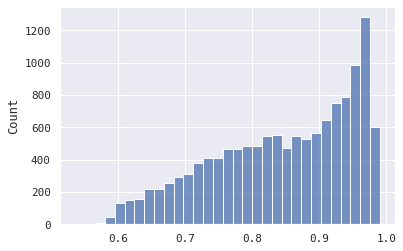

In [452]:
sns.histplot(auc_ll)

In [453]:
sum(auc_ll)/len(auc_ll)

0.8439316073712761

In [455]:
len(auc_ll_con)

8

0.5332116504427725
0.5104975609223948
0.5068489304205346
0.5451920010630175
0.5040269609550581
0.5108359075665246
0.5113596657432488
0.5224915083243008


IndexError: list index out of range

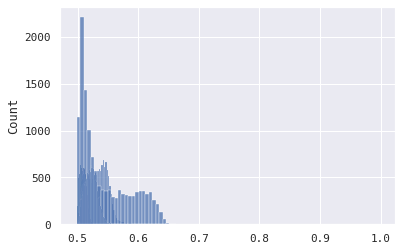

In [459]:
auc_ll_con_2 = []
for i, each_gene_score in enumerate(df_gene_tp_sel.index.tolist()):
    print (sum(auc_ll_con[i])/len(auc_ll_con[i]))
    sns.histplot(auc_ll_con[i])
    

In [434]:

calc_auroc(df_gene_tp_sel_sum,predicted_score='score')

0.9187018934191182

In [ ]:
df_gene_tp_sel.T['ENSG00000000419']



In [404]:
th = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/max/_totg_cre_auc_14.csv', sep='\t')

In [488]:
th[th.gene_id_exp_file.isin(high_auc_gene)]['auc'].mean()


0.6907919130581389

In [489]:
th[th.gene_id_exp_file.isin(high_auc_gene)]['auc'].max()

0.7940575632100098

In [487]:
th['auc'].max()

0.8149413612564936

<AxesSubplot:xlabel='auc', ylabel='Count'>

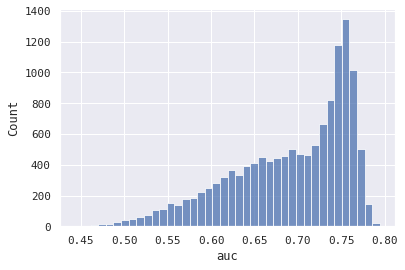

In [490]:
sns.histplot(th[th.gene_id_exp_file.isin(high_auc_gene)]['auc'])


In [468]:
th[th.gene_id_exp_file.isin(high_auc_gene)]


gene_id_exp_file       auc
0      ENSG00000000419  0.743154
1      ENSG00000000457  0.599157
2      ENSG00000000460  0.585266
3      ENSG00000000938  0.757391
4      ENSG00000000971  0.489380
...                ...       ...
55343  ENSG00000285280  0.540083
55356  ENSG00000285331  0.669822
55372  ENSG00000285399  0.655908
55379  ENSG00000285410  0.710762
55387  ENSG00000285437  0.693511

[13158 rows x 2 columns]

<AxesSubplot:xlabel='auc', ylabel='Count'>

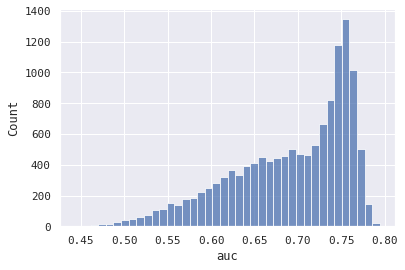

In [422]:
sns.histplot(th[th.gene_id_exp_file.isin(high_auc_gene)]['auc'])


In [386]:
def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(x)
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()


In [388]:
df_gene_tp_sel_sum



0           0
1         110
2          10
3          35
4          27
         ... 
287504    506
287505    262
287506    255
287507     61
287508      0
Length: 287509, dtype: int64

In [473]:
                with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_inter_bins_mean_none.h5', 'r') as hf:
    
                     data =  (((hf['mean'][()])));
                df_max_gene_inter_by_bins = pd.DataFrame(data)
                #df_max_gene_inter_by_bins['proj'] = proj
                df_max_gene_inter_by_bins = df_max_gene_inter_by_bins.reset_index()

                #df_max_gene_inter_by_bins = df_max_gene_inter_by_bins.merge(bins_bed, left_on='index', right_on='bin_id')


In [458]:
df_max_gene_inter_by_bins


NameError: name 'df_max_gene_inter_by_bins' is not defined

In [481]:
df_cre_1kb_encode

start_bin  cre    chr      start        end  bin_id  \
0           chr10_10000    1  chr10      10000      20000  167493   
1          chr10_100000    1  chr10     100000     110000  167502   
2         chr10_1000000    1  chr10    1000000    1010000  167592   
3        chr10_10000000    6  chr10   10000000   10010000  168492   
4       chr10_100000000   16  chr10  100000000  100010000  177492   
...                 ...  ...    ...        ...        ...     ...   
213396    chr9_99940000    1   chr9   99940000   99950000  163646   
213397    chr9_99950000    1   chr9   99950000   99960000  163647   
213398    chr9_99960000    1   chr9   99960000   99970000  163648   
213399    chr9_99970000    2   chr9   99970000   99980000  163649   
213400    chr9_99990000    1   chr9   99990000  100000000  163651   

                    pos  
0           chr10_10000  
1          chr10_100000  
2         chr10_1000000  
3        chr10_10000000  
4       chr10_100000000  
...                 ...  
213396    chr9_99940000  
213397    chr9_99950000  
213398    chr9_99960000  
213399    chr9_99970000  
213400    chr9_99990000  

[213401 rows x 7 columns]

In [483]:
    df_cre_tog = df_cre_1kb_encode.merge(df_max_gene_inter_by_bins, left_on='bin_id', right_on='index', how='right')

    df_cre_tog['cre'] = df_cre_tog['cre'].fillna(0)


    df_cre_tog['true_pos'] =  [1.0 if x>=14 else 0 for x in df_cre_tog['cre']]

    df_cre_tog['true_neg'] = [0 if x == 1.0 else 1.0 for x in df_cre_tog['true_pos']]
    df_cre_tog['score'] = df_cre_tog[0]
    calc_auroc (df_cre_tog,predicted_score='score')
    

0.734436321722935

In [480]:
df_cre_tog

start_bin  cre    chr       start         end    bin_id  \
0                  NaN  0.0    NaN         NaN         NaN       NaN   
1                  NaN  0.0    NaN         NaN         NaN       NaN   
2                  NaN  0.0    NaN         NaN         NaN       NaN   
3                  NaN  0.0    NaN         NaN         NaN       NaN   
4                  NaN  0.0    NaN         NaN         NaN       NaN   
...                ...  ...    ...         ...         ...       ...   
287504  chr22_50770000  1.0  chr22  50770000.0  50780000.0  287504.0   
287505  chr22_50780000  4.0  chr22  50780000.0  50790000.0  287505.0   
287506             NaN  0.0    NaN         NaN         NaN       NaN   
287507             NaN  0.0    NaN         NaN         NaN       NaN   
287508             NaN  0.0    NaN         NaN         NaN       NaN   

                   pos   index         0  true_pos  true_neg  
0                  NaN       0  0.000000       0.0       1.0  
1                  NaN       1  0.425253       0.0       1.0  
2                  NaN       2  0.054525       0.0       1.0  
3                  NaN       3  0.164977       0.0       1.0  
4                  NaN       4  0.177524       0.0       1.0  
...                ...     ...       ...       ...       ...  
287504  chr22_50770000  287504  1.459991       0.0       1.0  
287505  chr22_50780000  287505  0.937676       0.0       1.0  
287506             NaN  287506  0.891997       0.0       1.0  
287507             NaN  287507  0.261395       0.0       1.0  
287508             NaN  287508  0.000000       0.0       1.0  

[287509 rows x 11 columns]

In [14]:
exp_genes = pd.read_csv("/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/Homo_sapiens_average_rank.csv")

exp_genes['genes'] = [x.split('.')[0] for x in exp_genes['genes']]

exp_genes.set_index('genes', inplace=True)

exp_genes['avg_rank'] = exp_genes.sum(axis=1)

exp_genes['avg_rank'] = [ x/ exp_genes.shape[1] for x in  exp_genes['avg_rank']]

exp_genes = exp_genes[['avg_rank']]

exp_genes.reset_index(inplace=True)

exp_genes.drop_duplicates(['genes'], inplace=True)

high_auc_gene = exp_genes[exp_genes['avg_rank'] > 0.7]['genes'].tolist()

df_gene_tp_sel = df_gene_tp[df_gene_tp.index.isin(high_auc_gene)]

In [17]:
cre_bins = df_cre_1kb_encode[df_cre_1kb_encode['cre']>14]['bin_id'].tolist()

In [18]:
len(cre_bins)/3000

2.780666666666667

In [19]:
df_gene_tp_sel = df_gene_tp_sel[cre_bins]

In [20]:
df_2d_jac, go_chrom  = run_egad(df_gene_tp_sel, df_exp_corr)

(13157, 13157)
(13157, 8342)
0.9693905994526353
0.0


<ipython-input-2-46e24587dd68>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


In [22]:
%matplotlib inline
import seaborn as sns

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


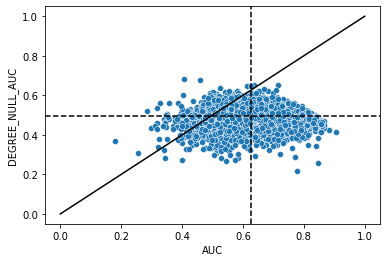

In [23]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [25]:
df_t = df_2d_jac.merge(df_gene_tp_sel.sum().reset_index(), left_on=df_2d_jac.index, right_on='index')


In [26]:
df_t

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value   index    0
0     0.548648     10432.251330         0.500019  2.071635e-02  177492  147
1     0.593454     10135.578246         0.442564  5.234711e-02  177557   26
2     0.536454     10060.668246         0.407840  2.975338e-01  177565   20
3     0.624543     10300.179106         0.478141  5.764654e-07  177566  127
4     0.461897     10385.444057         0.516128  6.432477e-02  177580  129
...        ...              ...              ...           ...     ...  ...
7876  0.601389     10454.027772         0.510980  1.831122e-08  163474  249
7877  0.560149     10544.321932         0.529888  4.074555e-03  163477  159
7878  0.525629     10027.908366         0.415976  2.571734e-01  163557   60
7879  0.660111     10531.933967         0.498688  3.683678e-03  163562   32
7880  0.692969     10628.637247         0.547172  1.431164e-17  163634  162

[7881 rows x 6 columns]

In [28]:
df_t['quintile'] = pd.qcut(df_t[0] , 10, labels=np.arange(10, 0, -1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quintile', ylabel='AUC'>

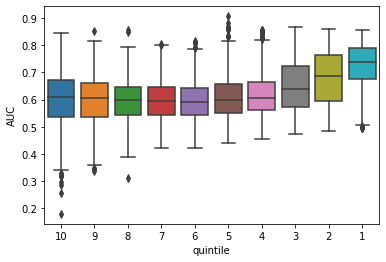

In [29]:
sns.boxplot(df_t['quintile'], df_t['AUC'])

In [55]:
high_auc_ind = df_t[df_t['quintile'] == 1]['index'].tolist()

In [57]:
df_gene_tp_sel[high_auc_ind]

177591  177716  177731  177735  177763  174719  177260  \
ENSG00000000419       0       0       0       0       0       1       0   
ENSG00000000457       0       0       0       0       0       0       0   
ENSG00000000460       0       0       0       0       0       0       0   
ENSG00000000938       1       1       0       0       0       1       0   
ENSG00000000971       0       0       0       0       0       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
ENSG00000285280       0       0       0       0       0       0       0   
ENSG00000285331       0       0       0       0       0       0       0   
ENSG00000285399       0       0       0       0       0       0       0   
ENSG00000285410       0       0       0       0       1       0       1   
ENSG00000285437       0       0       0       0       0       1       0   

                 191694  192715  192763  ...  167374  167376  167383  167412  \
ENSG00000000419       0       1       0  ...       0       0       0       0   
ENSG00000000457       0       0       0  ...       0       0       0       0   
ENSG00000000460       0       0       0  ...       0       0       0       0   
ENSG00000000938       0       0       0  ...       0       0       0       0   
ENSG00000000971       0       0       0  ...       0       0       0       0   
...                 ...     ...     ...  ...     ...     ...     ...     ...   
ENSG00000285280       0       0       0  ...       0       0       0       0   
ENSG00000285331       0       0       0  ...       0       0       0       0   
ENSG00000285399       0       0       0  ...       0       0       0       0   
ENSG00000285410       1       0       0  ...       0       0       0       0   
ENSG00000285437       0       0       1  ...       0       0       0       0   

                 167413  156954  156996  157089  157163  157217  
ENSG00000000419       0       0       0       0       0       0  
ENSG00000000457       0       0       0       0       0       0  
ENSG00000000460       0       0       0       0       0       0  
ENSG00000000938       0       0       0       0       0       0  
ENSG00000000971       0       0       0       0       0       0  
...                 ...     ...     ...     ...     ...     ...  
ENSG00000285280       0       0       0       0       0       0  
ENSG00000285331       0       1       0       1       0       0  
ENSG00000285399       0       0       0       0       0       0  
ENSG00000285410       0       1       0       1       0       0  
ENSG00000285437       0       0       0       0       0       0  

[13158 rows x 787 columns]

In [264]:
arr_gene = df_gene_tp_sel.to_numpy()

In [265]:
    zero_row_indices = np.where(~arr_gene.any(axis=1))[0] #[when the gene row sum is zero, its jaccard similarity is zero]
    


    jac_sim_gene = 1 - pairwise_distances(arr_gene, metric = "jaccard")  #[calculates the jaccard coefficient for each bin pair based on the , allbins X allbins where values are number of common neighbours]
    jac_sim_gene[zero_row_indices,:] = 0

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [266]:
np.fill_diagonal(jac_sim_gene, 1)

In [267]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
sns.set(font="monospace")

iris = load_iris()
X, y = iris.data, iris.target
DF = pd.DataFrame(X, index = ["iris_%d" % (i) for i in range(X.shape[0])], columns = iris.feature_names)

DF_corr = DF.T.corr()
DF_dism = 1 - jac_sim_gene   # distance matrix
linkage_gene = hc.linkage(sp.distance.squareform(DF_dism), method='average')
#sns.clustermap(DF_dism, row_linkage=linkage_gene, col_linkage=linkage_gene)

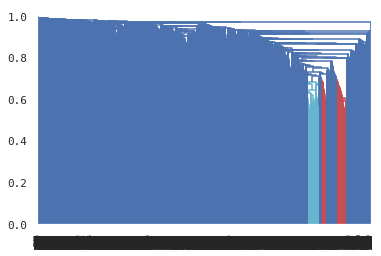

In [268]:
from scipy.cluster.hierarchy import dendrogram
 
# Create a dendrogram
dn = dendrogram(linkage_gene, distance_sort=True)
 
# Display the dendogram
plt.show()

In [352]:
cluster_labels = fcluster(linkage_gene, 0.7, criterion='distance')

In [353]:
from collections import Counter
z = list(cluster_labels)
z = Counter(z)

In [354]:
max(z.values())

468

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 30.0)

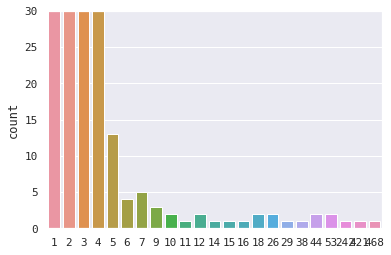

In [355]:
ax=sns.countplot(list(z.values()))
ax.set_ylim([0,30])

In [356]:
len(all_genes)

24243

In [357]:
df_exp_clust = pd.DataFrame(cluster_labels ,  index=df_gene_tp_sel.index.tolist())

df_exp_clust['label'] = df_exp_clust[0]

for clust, clust_len in zip(z.keys(), z.values()):
    if clust_len >= 5:
        
        print (clust, clust_len)
        df_exp_clust[clust] = [1 if x == clust else 0 for x in df_exp_clust['label'].tolist()]

9126 468
9141 242
9232 421
9061 44
8851 14
8754 16
9166 26
9171 53
9165 9
9121 18
9228 5
8749 5
8010 12
9134 5
9127 18
8755 5
9220 29
8966 5
9120 6
6901 12
9164 15
8858 44
9160 7
9060 10
8856 5
9035 38
9083 9
9098 53
8842 6
8831 5
8146 5
9140 9
9118 10
8854 7
8853 7
8882 5
8480 6
9499 6
8965 5
9133 11
9290 7
9169 26
8857 5
9288 7
6861 5
9199 5


In [358]:
df_exp_clust = df_exp_clust.drop(['label', 0], axis=1)

In [359]:
df_exp_clust

9126  9141  9232  9061  8851  8754  9166  9171  9165  9121  \
ENSG00000000419     0     0     0     0     0     0     0     0     0     0   
ENSG00000000457     0     0     0     0     0     0     0     0     0     0   
ENSG00000000460     0     0     0     0     0     0     0     0     0     0   
ENSG00000000938     0     0     0     0     0     0     0     0     0     0   
ENSG00000000971     0     0     0     0     0     0     0     0     0     0   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ENSG00000285280     0     0     0     0     0     0     0     0     0     0   
ENSG00000285331     0     0     0     0     0     0     0     0     0     0   
ENSG00000285399     0     0     0     0     0     0     0     0     0     0   
ENSG00000285410     0     0     0     0     0     0     0     0     0     0   
ENSG00000285437     0     0     0     0     0     0     0     0     0     0   

                 ...  8480  9499  8965  9133  9290  9169  8857  9288  6861  \
ENSG00000000419  ...     0     0     0     0     0     0     0     0     0   
ENSG00000000457  ...     0     0     0     0     0     0     0     0     0   
ENSG00000000460  ...     0     0     0     0     0     0     0     0     0   
ENSG00000000938  ...     0     0     0     0     0     0     0     0     0   
ENSG00000000971  ...     0     0     0     0     0     0     0     0     0   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ENSG00000285280  ...     0     0     0     0     0     0     0     0     0   
ENSG00000285331  ...     0     0     0     0     0     0     0     0     0   
ENSG00000285399  ...     0     0     0     0     0     0     0     0     0   
ENSG00000285410  ...     0     0     0     0     0     0     0     0     0   
ENSG00000285437  ...     0     0     0     0     0     0     0     0     0   

                 9199  
ENSG00000000419     0  
ENSG00000000457     0  
ENSG00000000460     0  
ENSG00000000938     0  
ENSG00000000971     0  
...               ...  
ENSG00000285280     0  
ENSG00000285331     0  
ENSG00000285399     0  
ENSG00000285410     0  
ENSG00000285437     0  

[13158 rows x 46 columns]

In [360]:
df_2d_jac, go_chrom  = run_egad(df_exp_clust, df_exp_corr)

(13157, 13157)
(13157, 46)
0.9971398924692096
0.0


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


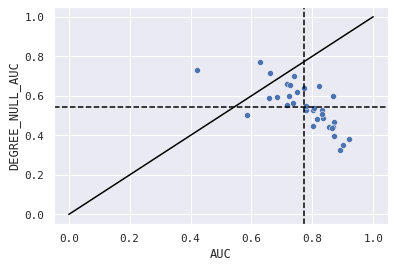

In [361]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [58]:
arr = df_gene_tp_sel[high_auc_ind].to_numpy().T

In [59]:
from sklearn.metrics.pairwise import pairwise_distances

In [60]:
    zero_row_indices = np.where(~arr.any(axis=1))[0] #[when the gene row sum is zero, its jaccard similarity is zero]
    


    jac_sim = 1 - pairwise_distances(arr, metric = "jaccard")  #[calculates the jaccard coefficient for each bin pair based on the , allbins X allbins where values are number of common neighbours]
    jac_sim[zero_row_indices,:] = 0

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [61]:
np.fill_diagonal(jac_sim, 1)

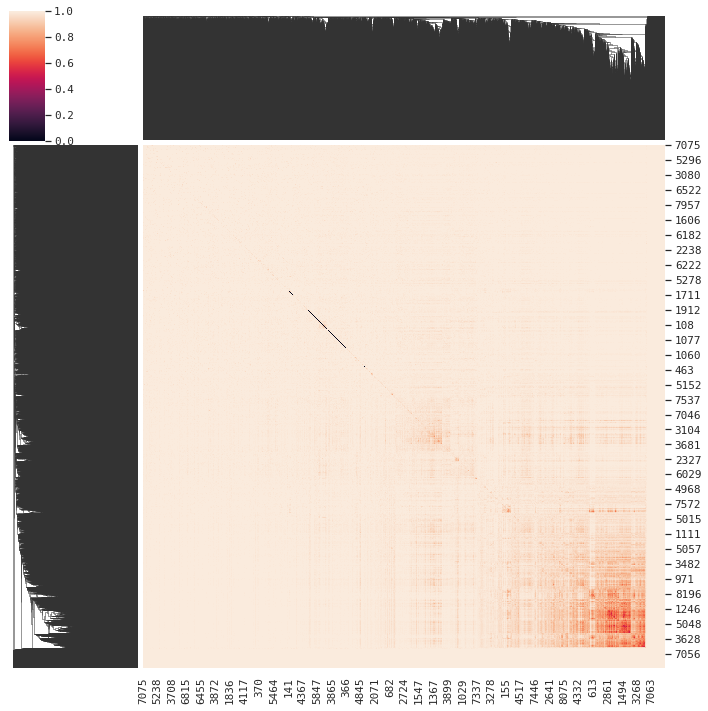

In [51]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
sns.set(font="monospace")

iris = load_iris()
X, y = iris.data, iris.target
DF = pd.DataFrame(X, index = ["iris_%d" % (i) for i in range(X.shape[0])], columns = iris.feature_names)

DF_corr = DF.T.corr()
DF_dism = 1 - jac_sim   # distance matrix
linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

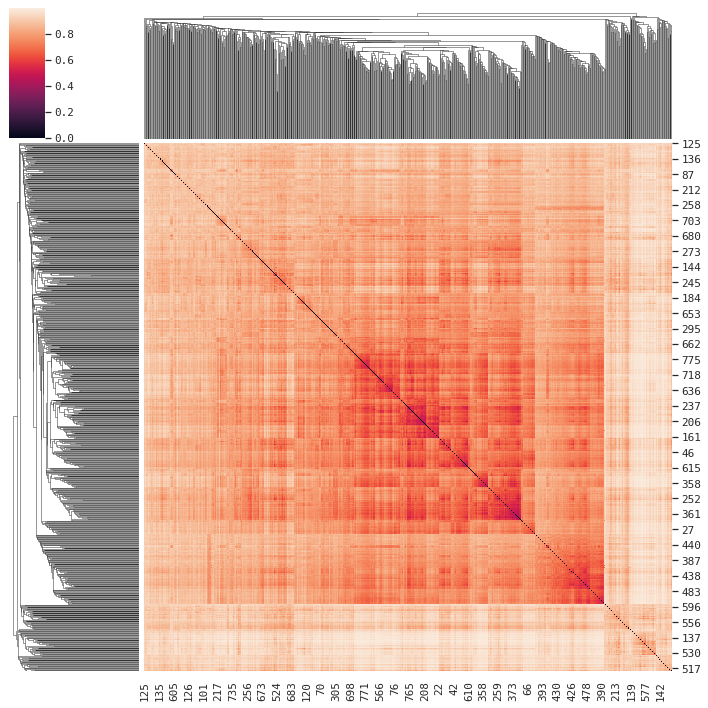

In [73]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
sns.set(font="monospace")

iris = load_iris()
X, y = iris.data, iris.target
DF = pd.DataFrame(X, index = ["iris_%d" % (i) for i in range(X.shape[0])], columns = iris.feature_names)

DF_corr = DF.T.corr()
DF_dism = 1 - jac_sim   # distance matrix
linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

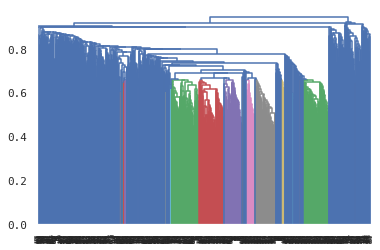

In [195]:
from scipy.cluster.hierarchy import dendrogram
 
# Create a dendrogram
dn = dendrogram(dist_mat, distance_sort=True)
 
# Display the dendogram
plt.show()

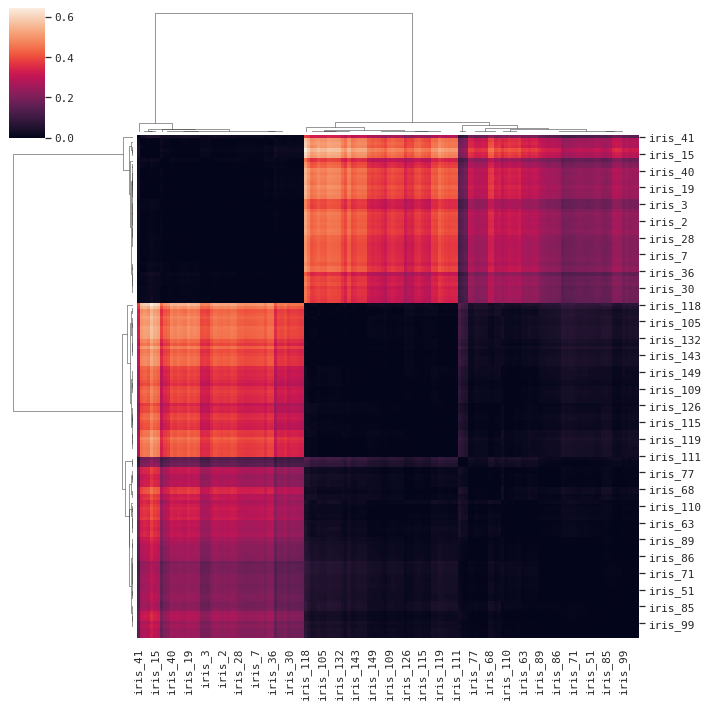

In [180]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
sns.set(font="monospace")

iris = load_iris()
X, y = iris.data, iris.target
DF = pd.DataFrame(X, index = ["iris_%d" % (i) for i in range(X.shape[0])], columns = iris.feature_names)

DF_corr = DF.T.corr()
DF_dism = 1 - DF_corr   # distance matrix
linkage_l = hc.linkage(sp.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage_l, col_linkage=linkage_l)

<AxesSubplot:>

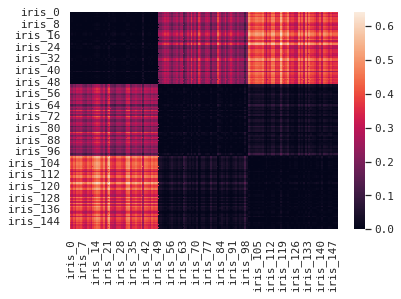

In [214]:
sns.heatmap(DF_dism)

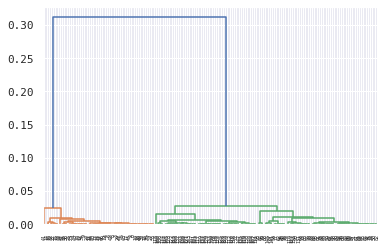

In [196]:
from scipy.cluster.hierarchy import dendrogram
 
# Create a dendrogram
dn = dendrogram(linkage_l, count_sort=True)
 
# Display the dendogram
plt.show()

In [219]:
fcluster(linkage_l, 0.02, criterion='distance')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4,
       3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3], dtype=int32)

In [178]:
max(dist_mat[:,2])*0.7

0.6629234656501589

In [ ]:
0.7*max(Z[:,2]

In [ ]:
dist_mat = linkage

In [236]:
from scipy.cluster.hierarchy import fcluster, linkage
cluster_labels = fcluster(dist_mat, 0.7, criterion='distance')

In [258]:
from scipy.cluster.hierarchy import fcluster, linkage
cluster_labels = fcluster(dist_mat, 50, criterion='maxclust')

In [171]:

plt.show()

In [248]:
cluster_labels

array([1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1,
       3, 3, 3, 1, 1, 3, 1, 2, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [262]:
df_t_1 = df_t[df_t['quintile'] == 1]

In [263]:
df_t_1['cluster_labels'] = cluster_labels 

<ipython-input-263-be9e3a9e7293>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_1['cluster_labels'] = cluster_labels


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='AUC'>

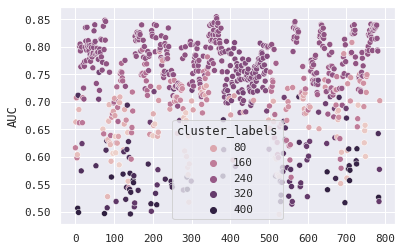

In [239]:
sns.scatterplot(df_t_1.reset_index().index, df_t_1['AUC'], hue=df_t_1['cluster_labels'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


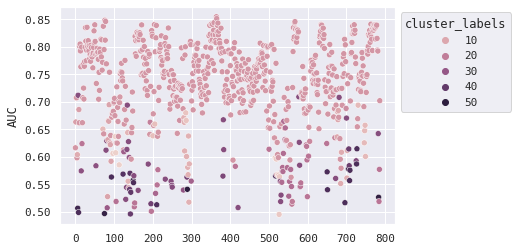

In [261]:
ax = sns.scatterplot(df_t_1.reset_index().index, df_t_1['AUC'], hue=df_t_1['cluster_labels'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [226]:
df_t_1

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC        P_Value   index     0  \
5     0.616393     10677.110581         0.574954   2.229388e-68  177591  1983   
14    0.663389     10572.340811         0.544111  9.583433e-105  177716  1536   
15    0.707153     10588.845815         0.539716  5.304060e-174  177731  1604   
18    0.707478     10582.908973         0.541711  2.018835e-234  177735  2206   
23    0.598158     10705.317871         0.588670   2.556946e-63  177763  2636   
...        ...              ...              ...            ...     ...   ...   
7761  0.642280     10809.833624         0.610719  2.569722e-122  156954  2442   
7766  0.526470     10515.706432         0.529004   6.451476e-04  156996  1277   
7769  0.518803     10666.100079         0.577176   8.463337e-04  157089  2503   
7774  0.577206     10723.243349         0.591732   8.175634e-38  157163  2467   
7778  0.702113     10578.250368         0.537783  3.649385e-188  157217  1839   

     quintile  cluster_labels  
5           1              44  
14          1              27  
15          1              44  
18          1              44  
23          1              44  
...       ...             ...  
7761        1              73  
7766        1              95  
7769        1              57  
7774        1              57  
7778        1              44  

[787 rows x 8 columns]

In [212]:
df_t_1.reset_index().index

level_0       AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC        P_Value  \
0          5  0.616393     10677.110581         0.574954   2.229388e-68   
1         14  0.663389     10572.340811         0.544111  9.583433e-105   
2         15  0.707153     10588.845815         0.539716  5.304060e-174   
3         18  0.707478     10582.908973         0.541711  2.018835e-234   
4         23  0.598158     10705.317871         0.588670   2.556946e-63   
..       ...       ...              ...              ...            ...   
782     7761  0.642280     10809.833624         0.610719  2.569722e-122   
783     7766  0.526470     10515.706432         0.529004   6.451476e-04   
784     7769  0.518803     10666.100079         0.577176   8.463337e-04   
785     7774  0.577206     10723.243349         0.591732   8.175634e-38   
786     7778  0.702113     10578.250368         0.537783  3.649385e-188   

      index     0 quintile  cluster_labels  
0    177591  1983        1               1  
1    177716  1536        1               1  
2    177731  1604        1               1  
3    177735  2206        1               1  
4    177763  2636        1               1  
..      ...   ...      ...             ...  
782  156954  2442        1               3  
783  156996  1277        1               4  
784  157089  2503        1               1  
785  157163  2467        1               1  
786  157217  1839        1               1  

[787 rows x 9 columns]

In [240]:
df_t_1['count'] = 1

<ipython-input-240-815082050133>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_1['count'] = 1


In [89]:
df_t_1.groupby(['cluster_labels'])['AUC', ]

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC        P_Value   index     0  \
5     0.616393     10677.110581         0.574954   2.229388e-68  177591  1983   
14    0.663389     10572.340811         0.544111  9.583433e-105  177716  1536   
15    0.707153     10588.845815         0.539716  5.304060e-174  177731  1604   
18    0.707478     10582.908973         0.541711  2.018835e-234  177735  2206   
23    0.598158     10705.317871         0.588670   2.556946e-63  177763  2636   
...        ...              ...              ...            ...     ...   ...   
7761  0.642280     10809.833624         0.610719  2.569722e-122  156954  2442   
7766  0.526470     10515.706432         0.529004   6.451476e-04  156996  1277   
7769  0.518803     10666.100079         0.577176   8.463337e-04  157089  2503   
7774  0.577206     10723.243349         0.591732   8.175634e-38  157163  2467   
7778  0.702113     10578.250368         0.537783  3.649385e-188  157217  1839   

     quintile  cluster_labels  
5           1             163  
14          1              50  
15          1             157  
18          1             158  
23          1             164  
...       ...             ...  
7761        1             439  
7766        1             488  
7769        1             401  
7774        1             402  
7778        1              95  

[787 rows x 8 columns]

In [108]:
df_t_1['cluster_labels']

5       143
14       48
15      140
18      140
23      144
       ... 
7761    269
7766    314
7769    236
7774    237
7778     93
Name: cluster_labels, Length: 787, dtype: int32

In [241]:
df_t_1.groupby(['cluster_labels'])['AUC'].mean().reset_index()

cluster_labels       AUC
0                 1  0.636854
1                 2  0.607362
2                 3  0.585396
3                 4  0.606201
4                 5  0.567897
..              ...       ...
403             404  0.506506
404             405  0.557196
405             406  0.496782
406             407  0.526470
407             408  0.540969

[408 rows x 2 columns]

In [244]:
df2 = df_t_1.groupby(['cluster_labels'])['count'].sum().reset_index().merge(df_t_1.groupby(['cluster_labels'])['AUC'].mean().reset_index())



In [242]:
df2 = df_t_1.groupby(['cluster_labels'])['count'].sum().reset_index().merge(df_t_1, left_on='cluster_labels', right_on='cluster_labels')


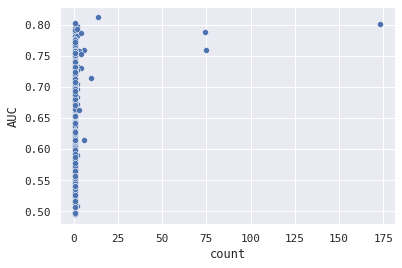

In [246]:
ax = sns.scatterplot(data=df2, x='count', y='AUC')
#ax.set_xlim(0,10)

In [372]:
df2['quintile'] = pd.qcut(df2['count'] , 5, labels=np.arange(5, 0, -1))

ValueError: Bin edges must be unique: array([  1.,   1.,   1.,   1.,   1., 173.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [374]:
df2['count_cat'] = ['count=1' if x<=1 else 'count>1' for x in df2['count']]

In [376]:
df2

cluster_labels  count       AUC count_cat
0                 1      1  0.636854   count=1
1                 2      1  0.607362   count=1
2                 3      1  0.585396   count=1
3                 4      1  0.606201   count=1
4                 5      1  0.567897   count=1
..              ...    ...       ...       ...
403             404      1  0.506506   count=1
404             405      1  0.557196   count=1
405             406      1  0.496782   count=1
406             407      1  0.526470   count=1
407             408      1  0.540969   count=1

[408 rows x 4 columns]

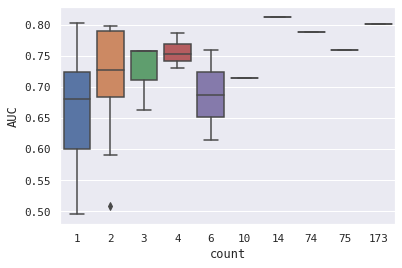

In [364]:
ax = sns.boxplot(data=df2, x='count', y='AUC')
#ax.set_xlim(0,10)

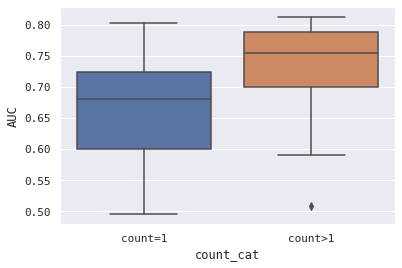

In [375]:
ax = sns.boxplot(data=df2, x='count_cat', y='AUC')

In [373]:
df2

cluster_labels  count       AUC
0                 1      1  0.636854
1                 2      1  0.607362
2                 3      1  0.585396
3                 4      1  0.606201
4                 5      1  0.567897
..              ...    ...       ...
403             404      1  0.506506
404             405      1  0.557196
405             406      1  0.496782
406             407      1  0.526470
407             408      1  0.540969

[408 rows x 3 columns]

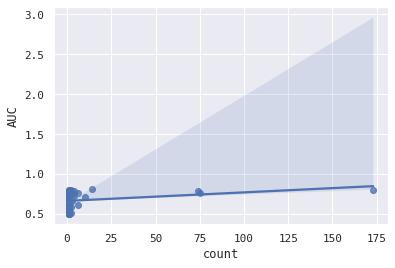

In [363]:
ax = sns.regplot(data=df2, x='count', y='AUC')

<AxesSubplot:xlabel='cluster_labels', ylabel='count'>

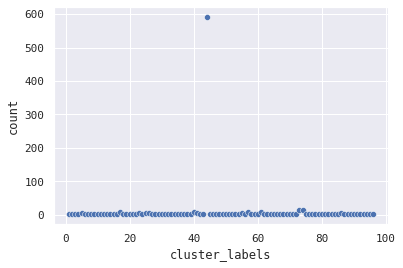

In [235]:
sns.scatterplot(data=df2, x='cluster_labels', y='count')

In [139]:
df2

cluster_labels  count_x       AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC  \
0                 1        1  0.636854     10516.923158         0.521466   
1                 2        1  0.607362     10588.852544         0.546131   
2                 3        1  0.585396     10653.907544         0.562805   
3                 4        1  0.606201     10416.235474         0.501428   
4                 5        1  0.567897     10505.054913         0.524402   
..              ...      ...       ...              ...              ...   
782             311        1  0.506506     10646.414809         0.559825   
783             312        1  0.557196     10593.966509         0.542024   
784             313        1  0.496782     10598.127132         0.548541   
785             314        1  0.526470     10515.706432         0.529004   
786             315        1  0.540969     10520.892851         0.531508   

          P_Value   index     0 quintile  count_y  
0    8.037594e-64  199809  1307        1        1  
1    4.187548e-43  199810  1413        1        1  
2    4.093480e-25  200156  1254        1        1  
3    4.661889e-41  199671  1370        1        1  
4    1.805022e-22    4038  1792        1        1  
..            ...     ...   ...      ...      ...  
782  1.860828e-01  177260  1297        1        1  
783  4.542107e-13  238760  1350        1        1  
784  2.980249e-01  188405  1256        1        1  
785  6.451476e-04  156996  1277        1        1  
786  4.745512e-07  255027  1238        1        1  

[787 rows x 10 columns]

<AxesSubplot:xlabel='count_x', ylabel='0'>

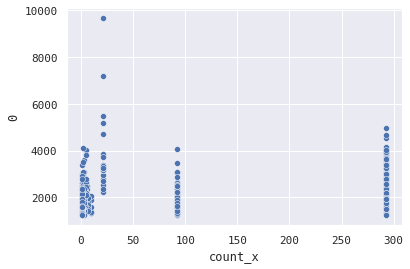

In [163]:
sns.scatterplot(data=df2, y=0, x='count_x')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 10.0)

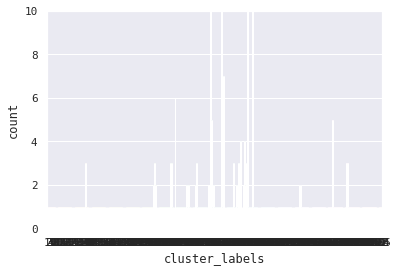

In [104]:
ax = sns.scatterplot(df_t_1['cluster_labels'], df_t_1['AUC'])
ax = sns.countplot(df_t_1['cluster_labels'])
ax.set_ylim([0,10])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster_labels', ylabel='AUC'>

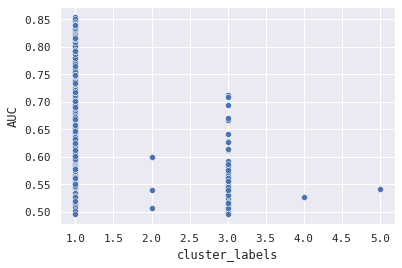

In [205]:
sns.scatterplot(df_t_1['cluster_labels'], df_t_1['AUC'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster_labels', ylabel='count'>

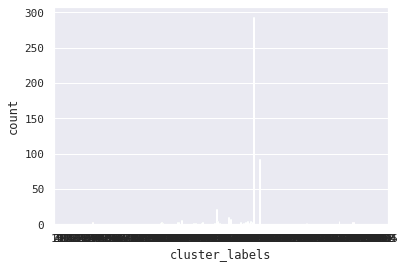

In [97]:
df_t_1['cluster_labels'].max()

315

In [86]:
df_t[df_t['quintile'] == 1]['index'].tolist()

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value   index    0  \
0     0.548648     10432.251330         0.500019  2.071635e-02  177492  147   
1     0.593454     10135.578246         0.442564  5.234711e-02  177557   26   
2     0.536454     10060.668246         0.407840  2.975338e-01  177565   20   
3     0.624543     10300.179106         0.478141  5.764654e-07  177566  127   
4     0.461897     10385.444057         0.516128  6.432477e-02  177580  129   
...        ...              ...              ...           ...     ...  ...   
7876  0.601389     10454.027772         0.510980  1.831122e-08  163474  249   
7877  0.560149     10544.321932         0.529888  4.074555e-03  163477  159   
7878  0.525629     10027.908366         0.415976  2.571734e-01  163557   60   
7879  0.660111     10531.933967         0.498688  3.683678e-03  163562   32   
7880  0.692969     10628.637247         0.547172  1.431164e-17  163634  162   

     quintile  
0           6  
1          10  
2          10  
3           6  
4           6  
...       ...  
7876        4  
7877        6  
7878        8  
7879        9  
7880        5  

[7881 rows x 7 columns]

In [83]:
dist_mat

array([[5.14000000e+02, 5.24000000e+02, 3.62843014e-01, 2.00000000e+00],
       [3.63000000e+02, 3.71000000e+02, 3.81848107e-01, 2.00000000e+00],
       [3.72000000e+02, 7.88000000e+02, 3.95659915e-01, 3.00000000e+00],
       ...,
       [1.56500000e+03, 1.56600000e+03, 9.22622612e-01, 7.27000000e+02],
       [2.89000000e+02, 1.56900000e+03, 9.26219682e-01, 6.00000000e+01],
       [1.57000000e+03, 1.57100000e+03, 9.47033522e-01, 7.87000000e+02]])